## MNIST DCGAN

Based on tutorial on pytorch c++ frontend https://pytorch.org/tutorials/advanced/cpp_frontend.html and on dcgan paper https://arxiv.org/pdf/1511.06434.pdf.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from time import time
import numpy as np

In [2]:
dev=torch.device('cpu')
if torch.cuda.is_available: dev=torch.device('cuda')
dev

device(type='cuda')

In [3]:
ds=datasets.MNIST('data',download=True,train=True,transform=T.ToTensor())

Layer width in generator is reversed compared to common convnet. This seems logical, since here we start w/ pretty small information, so we "boost" it in the 1st layer using maximum channels. Also num of channels has to gradually drop towards the end since the final layer is an normal image, so wider layers are placed at the beginning of network.

Sigmoid instead of paper's tanh worked equally well for mnist.

In [4]:
def getgen():
    return nn.Sequential(
        nn.ConvTranspose2d(100,256,4,bias=False) #4
        ,nn.BatchNorm2d(256),nn.ReLU()
        ,nn.ConvTranspose2d(256,128,3,stride=2,padding=1,bias=False) #7
        ,nn.BatchNorm2d(128),nn.ReLU()
        ,nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False) #14
        ,nn.BatchNorm2d(64),nn.ReLU()
        ,nn.ConvTranspose2d(64,1,4,stride=2,padding=1,bias=False) #28
        ,nn.Sigmoid()
    ).to(dev)

Tried ReLU instead of LeakyReLU for 1 training session of 3 epochs. It seemed like leaky variant is indeed better.

In [5]:
class Squeeze(nn.Module):
    def forward(self,x): return x.squeeze()

def getdiscr():
    return nn.Sequential(
        nn.Conv2d(1,64,4,stride=2,padding=1,bias=False) #14
        ,nn.LeakyReLU(.2)
        ,nn.Conv2d(64,128,4,stride=2,padding=1,bias=False) #7
        ,nn.BatchNorm2d(128),nn.LeakyReLU(.2)
        ,nn.Conv2d(128,256,4,stride=2,padding=1,bias=False) #3
        ,nn.BatchNorm2d(256),nn.LeakyReLU(.2)
        ,nn.Conv2d(256,1,3,bias=False) #1
        ,Squeeze()
        ,nn.Sigmoid()
    ).to(dev)

In [6]:
gen_lr=2e-4
discr_lr=5e-4
betas=(.5,.999)
bs=100
n_noise=100 # num of input noise pixels

dl=data.DataLoader(ds,batch_size=bs,shuffle=True)
gen=getgen()
discr=getdiscr()
gen_opt=optim.Adam(gen.parameters(),lr=gen_lr,betas=betas)
discr_opt=optim.Adam(discr.parameters(),lr=discr_lr,betas=betas)
losses={'dloss_real':[],'dloss_fake':[],'gloss':[]}

In [7]:
@torch.no_grad()
def z2img(z): return gen(z).detach().cpu().squeeze().numpy()
def genimg():
    z=torch.randn(1,n_noise,1,1,device=dev)
    return z2img(z),z

def showimgs(n=3):
    _,axes=plt.subplots(n,n,figsize=(12,8))
    for i in range(n*n):
        ax=axes[i//n,i%n]
        img,z=genimg()
        ax.imshow(img,cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.title.set_text(round(discr(gen(z)).item(),2))
    plt.show()

In [8]:
def train(epochs):
    t0=time()
    for ep in range(epochs):
        for i,(xb,yb) in enumerate(dl):
            discr_opt.zero_grad()
            xb=xb.to(dev)
            yb=torch.empty(yb.shape,device=dev).uniform_(.8,1.) # label smoothing
            dloss_real=F.binary_cross_entropy(discr(xb),yb)
            dloss_real.backward()
            losses['dloss_real'].append(dloss_real.item())

            zb=torch.randn(xb.shape[0],n_noise,1,1,device=dev)
            gb=gen(zb)
            yb=torch.zeros_like(yb)
            # note: gen images are detached, so no gen grads are calculated
            dloss_fake=F.binary_cross_entropy(discr(gb.detach()),yb)
            dloss_fake.backward()
            losses['dloss_fake'].append(dloss_fake.item())
            discr_opt.step()

            gen_opt.zero_grad()
            yb=torch.ones_like(yb)
            gloss=F.binary_cross_entropy(discr(gb),yb)
            gloss.backward()
            losses['gloss'].append(gloss.item())
            gen_opt.step()

            print('[%2d/%2d][%3d/%3d] dloss_real=%.4f dloss_fake=%.4f gloss=%.4f'%
                  (ep+1,epochs,i+1,len(dl),dloss_real,dloss_fake,gloss))
            if (i+1)%100==0:
                print('elapsed time',time()-t0,'s')
                showimgs()

    print('total time',time()-t0,'s')

Training appears to be quite random. One time it starts to gen pretty perfect images after just 3 epochs, other times 5 epochs is not enough. After some initial progress it seems to start going in circles w/out improvement.

[ 1/10][  1/600] dloss_real=0.7275 dloss_fake=0.6404 gloss=3.5730
[ 1/10][  2/600] dloss_real=0.3488 dloss_fake=0.1028 gloss=4.7720
[ 1/10][  3/600] dloss_real=0.3760 dloss_fake=0.0308 gloss=5.1910
[ 1/10][  4/600] dloss_real=0.3559 dloss_fake=0.0164 gloss=5.1659
[ 1/10][  5/600] dloss_real=0.3621 dloss_fake=0.0147 gloss=5.1650
[ 1/10][  6/600] dloss_real=0.3376 dloss_fake=0.0129 gloss=5.7163
[ 1/10][  7/600] dloss_real=0.3295 dloss_fake=0.0058 gloss=5.7361
[ 1/10][  8/600] dloss_real=0.3288 dloss_fake=0.0080 gloss=5.6725
[ 1/10][  9/600] dloss_real=0.3275 dloss_fake=0.0077 gloss=5.8712
[ 1/10][ 10/600] dloss_real=0.3453 dloss_fake=0.0060 gloss=5.8460
[ 1/10][ 11/600] dloss_real=0.3255 dloss_fake=0.0061 gloss=5.2486
[ 1/10][ 12/600] dloss_real=0.3462 dloss_fake=0.0127 gloss=6.3213
[ 1/10][ 13/600] dloss_real=0.3140 dloss_fake=0.0031 gloss=5.7039
[ 1/10][ 14/600] dloss_real=0.3584 dloss_fake=0.0082 gloss=6.3545
[ 1/10][ 15/600] dloss_real=0.3221 dloss_fake=0.0034 gloss=6.2402
[ 1/10][ 1

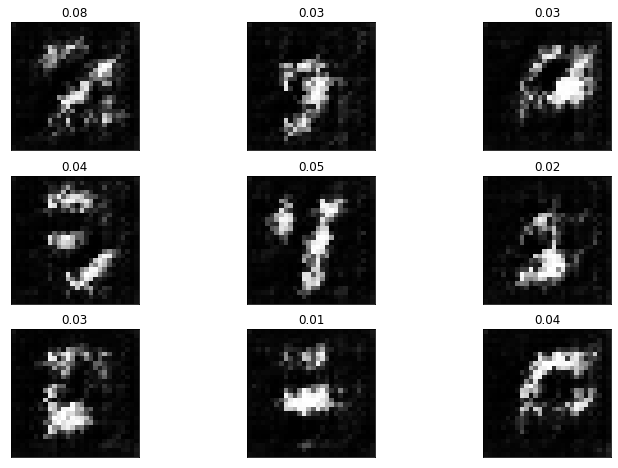

[ 1/10][101/600] dloss_real=0.4334 dloss_fake=0.0530 gloss=2.3850
[ 1/10][102/600] dloss_real=0.3434 dloss_fake=0.3077 gloss=5.8743
[ 1/10][103/600] dloss_real=1.1203 dloss_fake=0.0074 gloss=0.6876
[ 1/10][104/600] dloss_real=0.4681 dloss_fake=1.3805 gloss=5.2335
[ 1/10][105/600] dloss_real=0.6755 dloss_fake=0.0207 gloss=3.7169
[ 1/10][106/600] dloss_real=0.4929 dloss_fake=0.1023 gloss=1.9006
[ 1/10][107/600] dloss_real=0.3446 dloss_fake=0.5585 gloss=3.7346
[ 1/10][108/600] dloss_real=0.7493 dloss_fake=0.0559 gloss=2.3294
[ 1/10][109/600] dloss_real=0.3883 dloss_fake=0.2146 gloss=2.2976
[ 1/10][110/600] dloss_real=0.3722 dloss_fake=0.2064 gloss=3.3703
[ 1/10][111/600] dloss_real=0.4640 dloss_fake=0.0699 gloss=2.6157
[ 1/10][112/600] dloss_real=0.3740 dloss_fake=0.1676 gloss=2.9849
[ 1/10][113/600] dloss_real=0.3920 dloss_fake=0.1137 gloss=3.1417
[ 1/10][114/600] dloss_real=0.4621 dloss_fake=0.0912 gloss=2.3816
[ 1/10][115/600] dloss_real=0.3432 dloss_fake=0.1664 gloss=3.2782
[ 1/10][11

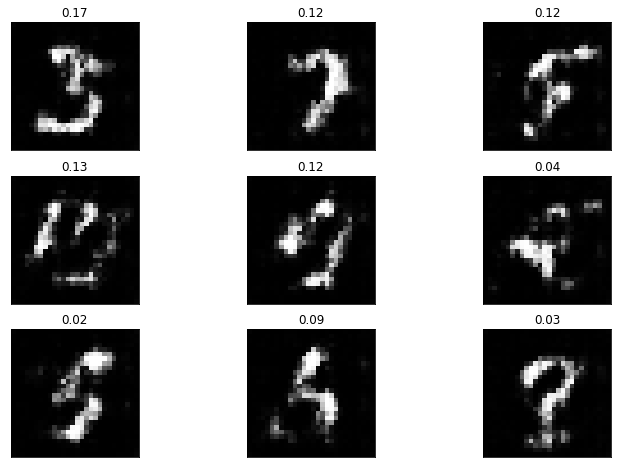

[ 1/10][201/600] dloss_real=0.5087 dloss_fake=0.0662 gloss=3.0459
[ 1/10][202/600] dloss_real=0.4674 dloss_fake=0.1532 gloss=2.0387
[ 1/10][203/600] dloss_real=0.3793 dloss_fake=0.4292 gloss=3.6040
[ 1/10][204/600] dloss_real=0.8585 dloss_fake=0.0855 gloss=1.1052
[ 1/10][205/600] dloss_real=0.3632 dloss_fake=0.8388 gloss=4.7823
[ 1/10][206/600] dloss_real=1.3652 dloss_fake=0.0180 gloss=2.2483
[ 1/10][207/600] dloss_real=0.3313 dloss_fake=0.3058 gloss=2.2420
[ 1/10][208/600] dloss_real=0.3355 dloss_fake=0.3346 gloss=3.4257
[ 1/10][209/600] dloss_real=0.6453 dloss_fake=0.1073 gloss=2.2193
[ 1/10][210/600] dloss_real=0.4604 dloss_fake=0.3124 gloss=2.2653
[ 1/10][211/600] dloss_real=0.5290 dloss_fake=0.2789 gloss=2.3559
[ 1/10][212/600] dloss_real=0.4973 dloss_fake=0.2691 gloss=2.6786
[ 1/10][213/600] dloss_real=0.4969 dloss_fake=0.1315 gloss=2.4801
[ 1/10][214/600] dloss_real=0.3882 dloss_fake=0.1923 gloss=2.8690
[ 1/10][215/600] dloss_real=0.3689 dloss_fake=0.1553 gloss=3.2124
[ 1/10][21

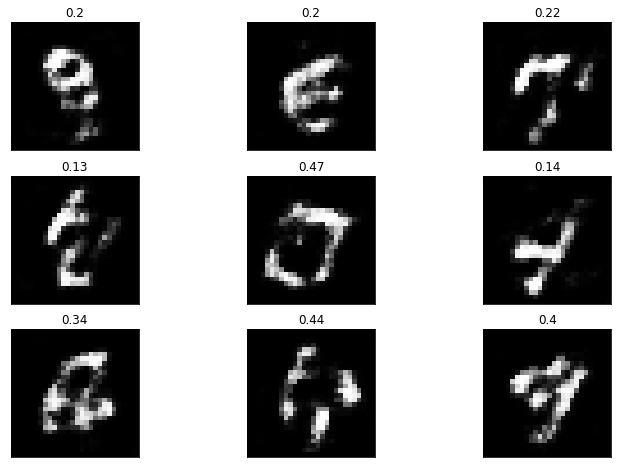

[ 1/10][301/600] dloss_real=0.4187 dloss_fake=0.3154 gloss=2.0304
[ 1/10][302/600] dloss_real=0.4520 dloss_fake=0.2383 gloss=2.4435
[ 1/10][303/600] dloss_real=0.5074 dloss_fake=0.1797 gloss=2.1899
[ 1/10][304/600] dloss_real=0.4492 dloss_fake=0.1978 gloss=2.2632
[ 1/10][305/600] dloss_real=0.4286 dloss_fake=0.1750 gloss=2.7217
[ 1/10][306/600] dloss_real=0.4597 dloss_fake=0.1176 gloss=2.5330
[ 1/10][307/600] dloss_real=0.3729 dloss_fake=0.1603 gloss=2.9767
[ 1/10][308/600] dloss_real=0.4153 dloss_fake=0.1116 gloss=2.6445
[ 1/10][309/600] dloss_real=0.4359 dloss_fake=0.1290 gloss=2.3428
[ 1/10][310/600] dloss_real=0.3874 dloss_fake=0.2262 gloss=3.3463
[ 1/10][311/600] dloss_real=0.5447 dloss_fake=0.0740 gloss=1.9890
[ 1/10][312/600] dloss_real=0.3551 dloss_fake=0.2536 gloss=2.9522
[ 1/10][313/600] dloss_real=0.4871 dloss_fake=0.1017 gloss=2.3875
[ 1/10][314/600] dloss_real=0.3876 dloss_fake=0.2165 gloss=2.8435
[ 1/10][315/600] dloss_real=0.4552 dloss_fake=0.0746 gloss=2.2441
[ 1/10][31

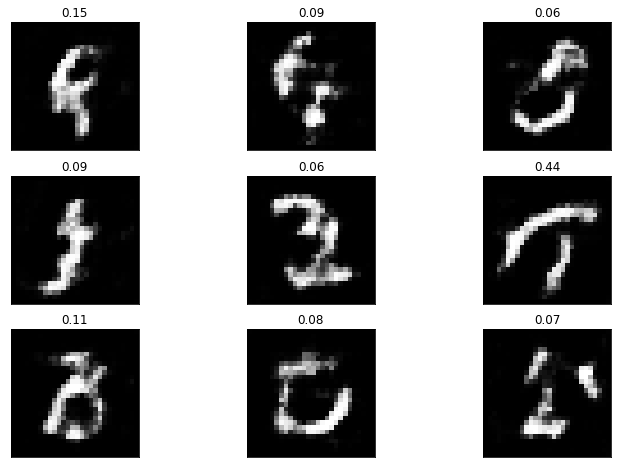

[ 1/10][401/600] dloss_real=0.4126 dloss_fake=0.1706 gloss=2.4890
[ 1/10][402/600] dloss_real=0.4114 dloss_fake=0.1481 gloss=2.5341
[ 1/10][403/600] dloss_real=0.4367 dloss_fake=0.1215 gloss=2.2033
[ 1/10][404/600] dloss_real=0.4018 dloss_fake=0.2117 gloss=2.4405
[ 1/10][405/600] dloss_real=0.4213 dloss_fake=0.1465 gloss=2.8716
[ 1/10][406/600] dloss_real=0.4391 dloss_fake=0.0976 gloss=2.5088
[ 1/10][407/600] dloss_real=0.3917 dloss_fake=0.1382 gloss=2.6139
[ 1/10][408/600] dloss_real=0.4153 dloss_fake=0.1187 gloss=2.3058
[ 1/10][409/600] dloss_real=0.3692 dloss_fake=0.1818 gloss=3.5544
[ 1/10][410/600] dloss_real=0.6175 dloss_fake=0.0646 gloss=1.3208
[ 1/10][411/600] dloss_real=0.3415 dloss_fake=0.4195 gloss=4.2661
[ 1/10][412/600] dloss_real=0.8010 dloss_fake=0.0257 gloss=1.4342
[ 1/10][413/600] dloss_real=0.3539 dloss_fake=0.4761 gloss=3.6303
[ 1/10][414/600] dloss_real=0.6405 dloss_fake=0.0613 gloss=1.9365
[ 1/10][415/600] dloss_real=0.3549 dloss_fake=0.2876 gloss=2.9401
[ 1/10][41

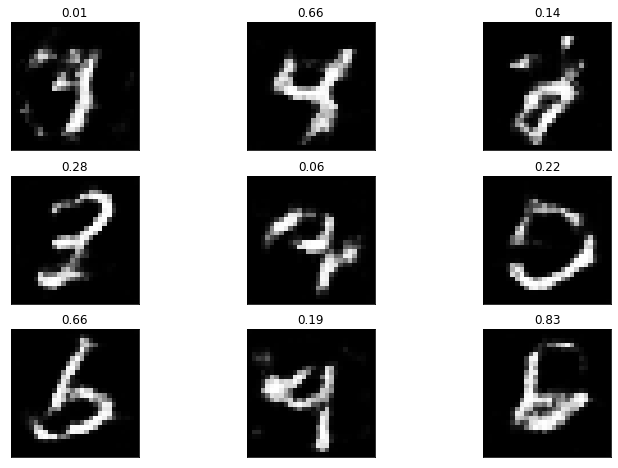

[ 1/10][501/600] dloss_real=0.3805 dloss_fake=0.5415 gloss=5.1313
[ 1/10][502/600] dloss_real=1.4541 dloss_fake=0.0140 gloss=0.6760
[ 1/10][503/600] dloss_real=0.3923 dloss_fake=1.0220 gloss=4.3817
[ 1/10][504/600] dloss_real=0.9812 dloss_fake=0.0274 gloss=1.6640
[ 1/10][505/600] dloss_real=0.4120 dloss_fake=0.4310 gloss=2.7238
[ 1/10][506/600] dloss_real=0.5615 dloss_fake=0.1631 gloss=2.2955
[ 1/10][507/600] dloss_real=0.4620 dloss_fake=0.1923 gloss=2.1049
[ 1/10][508/600] dloss_real=0.4616 dloss_fake=0.2797 gloss=2.6093
[ 1/10][509/600] dloss_real=0.5220 dloss_fake=0.1387 gloss=1.8886
[ 1/10][510/600] dloss_real=0.3827 dloss_fake=0.2066 gloss=2.7095
[ 1/10][511/600] dloss_real=0.5629 dloss_fake=0.2026 gloss=1.9742
[ 1/10][512/600] dloss_real=0.4104 dloss_fake=0.1789 gloss=2.7168
[ 1/10][513/600] dloss_real=0.4553 dloss_fake=0.1615 gloss=2.1977
[ 1/10][514/600] dloss_real=0.4178 dloss_fake=0.1432 gloss=2.1966
[ 1/10][515/600] dloss_real=0.4033 dloss_fake=0.2252 gloss=3.0173
[ 1/10][51

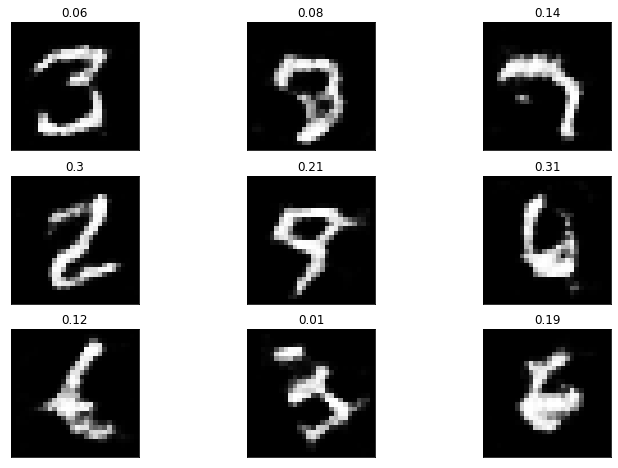

[ 2/10][  1/600] dloss_real=0.3852 dloss_fake=0.2784 gloss=2.8745
[ 2/10][  2/600] dloss_real=0.5272 dloss_fake=0.0891 gloss=2.0202
[ 2/10][  3/600] dloss_real=0.3767 dloss_fake=0.2402 gloss=2.5452
[ 2/10][  4/600] dloss_real=0.4171 dloss_fake=0.1117 gloss=2.5695
[ 2/10][  5/600] dloss_real=0.3948 dloss_fake=0.1359 gloss=2.4744
[ 2/10][  6/600] dloss_real=0.4236 dloss_fake=0.1689 gloss=2.5568
[ 2/10][  7/600] dloss_real=0.4644 dloss_fake=0.1641 gloss=2.4789
[ 2/10][  8/600] dloss_real=0.5546 dloss_fake=0.1208 gloss=1.1463
[ 2/10][  9/600] dloss_real=0.3757 dloss_fake=0.5704 gloss=4.7096
[ 2/10][ 10/600] dloss_real=1.1743 dloss_fake=0.0353 gloss=1.1742
[ 2/10][ 11/600] dloss_real=0.3693 dloss_fake=0.4815 gloss=2.6310
[ 2/10][ 12/600] dloss_real=0.4568 dloss_fake=0.1779 gloss=2.9892
[ 2/10][ 13/600] dloss_real=0.6265 dloss_fake=0.1075 gloss=1.5851
[ 2/10][ 14/600] dloss_real=0.3618 dloss_fake=0.3775 gloss=2.9243
[ 2/10][ 15/600] dloss_real=0.5813 dloss_fake=0.1156 gloss=2.3834
[ 2/10][ 1

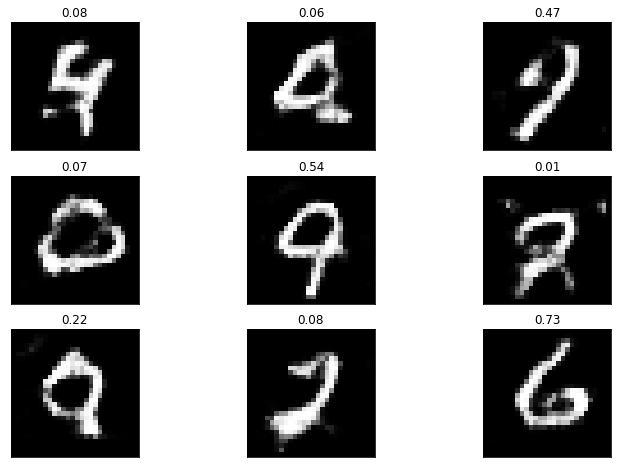

[ 2/10][101/600] dloss_real=0.4300 dloss_fake=0.1404 gloss=2.4847
[ 2/10][102/600] dloss_real=0.3990 dloss_fake=0.1898 gloss=2.7128
[ 2/10][103/600] dloss_real=0.4824 dloss_fake=0.1214 gloss=2.1321
[ 2/10][104/600] dloss_real=0.4582 dloss_fake=0.2144 gloss=1.8703
[ 2/10][105/600] dloss_real=0.3717 dloss_fake=0.2108 gloss=2.9636
[ 2/10][106/600] dloss_real=0.4282 dloss_fake=0.1043 gloss=2.4203
[ 2/10][107/600] dloss_real=0.5111 dloss_fake=0.1569 gloss=1.6116
[ 2/10][108/600] dloss_real=0.3326 dloss_fake=0.3758 gloss=4.2235
[ 2/10][109/600] dloss_real=1.0393 dloss_fake=0.0298 gloss=0.6615
[ 2/10][110/600] dloss_real=0.3968 dloss_fake=0.9035 gloss=4.5224
[ 2/10][111/600] dloss_real=1.7658 dloss_fake=0.0222 gloss=0.7900
[ 2/10][112/600] dloss_real=0.3522 dloss_fake=0.8581 gloss=2.5898
[ 2/10][113/600] dloss_real=0.7423 dloss_fake=0.1031 gloss=1.8938
[ 2/10][114/600] dloss_real=0.4157 dloss_fake=0.3953 gloss=2.0199
[ 2/10][115/600] dloss_real=0.4721 dloss_fake=0.2480 gloss=2.0371
[ 2/10][11

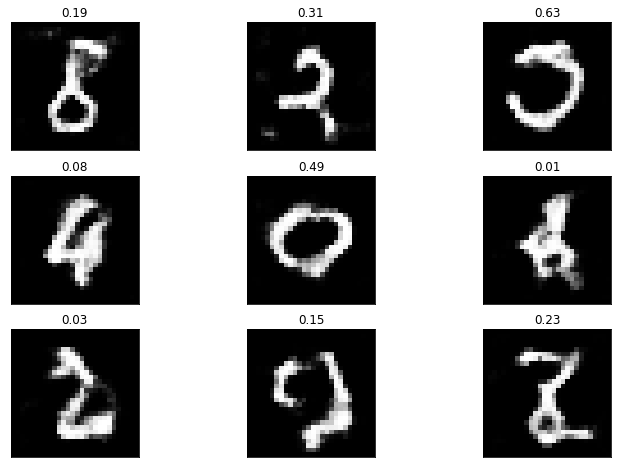

[ 2/10][201/600] dloss_real=0.3887 dloss_fake=0.3799 gloss=2.9198
[ 2/10][202/600] dloss_real=0.6196 dloss_fake=0.1386 gloss=2.0184
[ 2/10][203/600] dloss_real=0.4422 dloss_fake=0.2103 gloss=2.1811
[ 2/10][204/600] dloss_real=0.4505 dloss_fake=0.1959 gloss=2.2720
[ 2/10][205/600] dloss_real=0.4003 dloss_fake=0.2468 gloss=3.2597
[ 2/10][206/600] dloss_real=0.6278 dloss_fake=0.0759 gloss=1.2649
[ 2/10][207/600] dloss_real=0.3584 dloss_fake=0.3934 gloss=2.9214
[ 2/10][208/600] dloss_real=0.5294 dloss_fake=0.1594 gloss=2.3186
[ 2/10][209/600] dloss_real=0.5261 dloss_fake=0.1398 gloss=1.7472
[ 2/10][210/600] dloss_real=0.3767 dloss_fake=0.3144 gloss=3.1135
[ 2/10][211/600] dloss_real=0.6067 dloss_fake=0.0933 gloss=1.7220
[ 2/10][212/600] dloss_real=0.3986 dloss_fake=0.3521 gloss=2.6264
[ 2/10][213/600] dloss_real=0.5281 dloss_fake=0.1487 gloss=2.3976
[ 2/10][214/600] dloss_real=0.4656 dloss_fake=0.2518 gloss=2.0506
[ 2/10][215/600] dloss_real=0.5355 dloss_fake=0.1822 gloss=1.8131
[ 2/10][21

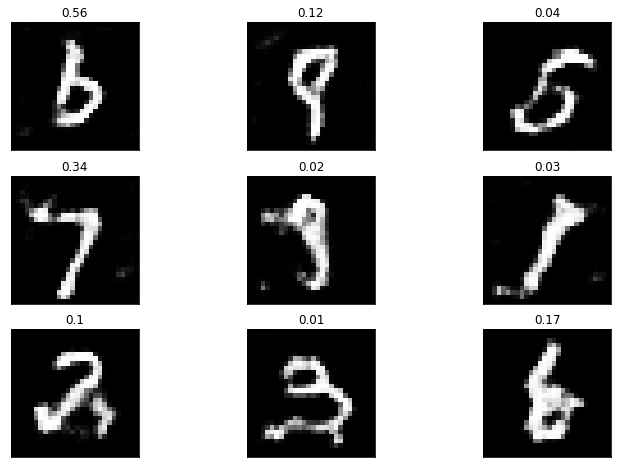

[ 2/10][301/600] dloss_real=0.4660 dloss_fake=0.1992 gloss=2.1506
[ 2/10][302/600] dloss_real=0.4097 dloss_fake=0.2596 gloss=2.6666
[ 2/10][303/600] dloss_real=0.6704 dloss_fake=0.0989 gloss=1.1785
[ 2/10][304/600] dloss_real=0.3810 dloss_fake=0.6441 gloss=3.9066
[ 2/10][305/600] dloss_real=1.0623 dloss_fake=0.0545 gloss=1.3461
[ 2/10][306/600] dloss_real=0.3685 dloss_fake=0.4767 gloss=2.8418
[ 2/10][307/600] dloss_real=0.8780 dloss_fake=0.1001 gloss=0.9345
[ 2/10][308/600] dloss_real=0.3422 dloss_fake=0.6231 gloss=2.8160
[ 2/10][309/600] dloss_real=0.7037 dloss_fake=0.1180 gloss=1.9179
[ 2/10][310/600] dloss_real=0.4327 dloss_fake=0.3016 gloss=2.0419
[ 2/10][311/600] dloss_real=0.5663 dloss_fake=0.3187 gloss=1.7250
[ 2/10][312/600] dloss_real=0.5140 dloss_fake=0.2700 gloss=2.0391
[ 2/10][313/600] dloss_real=0.5223 dloss_fake=0.2316 gloss=1.8960
[ 2/10][314/600] dloss_real=0.4452 dloss_fake=0.2246 gloss=2.5195
[ 2/10][315/600] dloss_real=0.4258 dloss_fake=0.2837 gloss=3.0795
[ 2/10][31

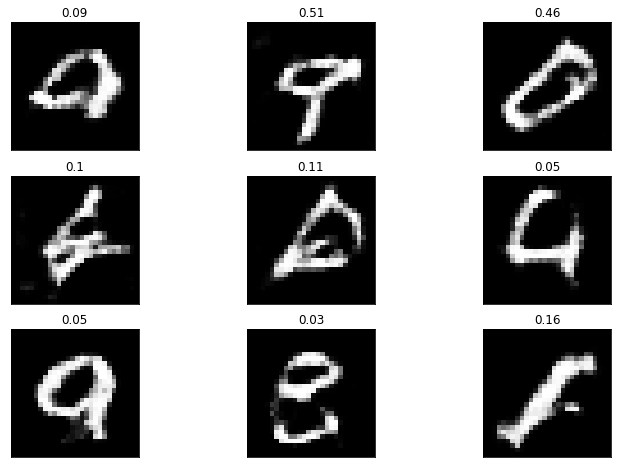

[ 2/10][401/600] dloss_real=0.3906 dloss_fake=0.4104 gloss=2.4199
[ 2/10][402/600] dloss_real=0.5957 dloss_fake=0.1890 gloss=2.0397
[ 2/10][403/600] dloss_real=0.4536 dloss_fake=0.3130 gloss=2.2728
[ 2/10][404/600] dloss_real=0.5288 dloss_fake=0.1636 gloss=2.1285
[ 2/10][405/600] dloss_real=0.4396 dloss_fake=0.2679 gloss=2.3911
[ 2/10][406/600] dloss_real=0.5116 dloss_fake=0.1287 gloss=2.2552
[ 2/10][407/600] dloss_real=0.3925 dloss_fake=0.2443 gloss=2.7439
[ 2/10][408/600] dloss_real=0.5006 dloss_fake=0.1240 gloss=2.5144
[ 2/10][409/600] dloss_real=0.4519 dloss_fake=0.1396 gloss=2.0731
[ 2/10][410/600] dloss_real=0.4554 dloss_fake=0.2412 gloss=2.1164
[ 2/10][411/600] dloss_real=0.4157 dloss_fake=0.2555 gloss=3.3241
[ 2/10][412/600] dloss_real=0.6018 dloss_fake=0.0978 gloss=1.3416
[ 2/10][413/600] dloss_real=0.3893 dloss_fake=0.3740 gloss=3.3039
[ 2/10][414/600] dloss_real=0.7035 dloss_fake=0.0687 gloss=1.7651
[ 2/10][415/600] dloss_real=0.3854 dloss_fake=0.3077 gloss=3.2427
[ 2/10][41

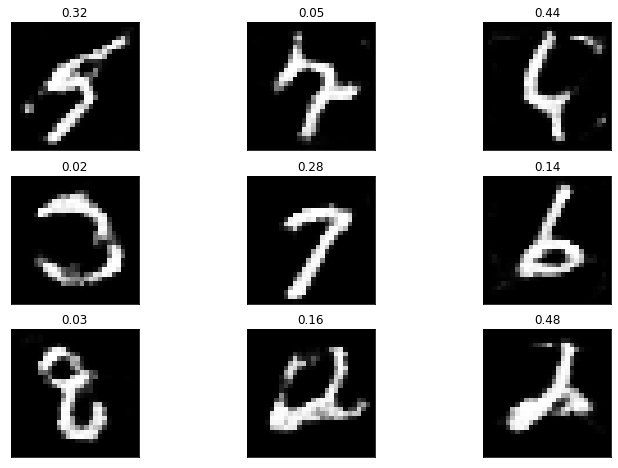

[ 2/10][501/600] dloss_real=0.5137 dloss_fake=0.2916 gloss=1.8806
[ 2/10][502/600] dloss_real=0.5183 dloss_fake=0.2868 gloss=2.0621
[ 2/10][503/600] dloss_real=0.4756 dloss_fake=0.2202 gloss=2.1997
[ 2/10][504/600] dloss_real=0.4960 dloss_fake=0.2515 gloss=2.1474
[ 2/10][505/600] dloss_real=0.5224 dloss_fake=0.1815 gloss=1.9109
[ 2/10][506/600] dloss_real=0.4218 dloss_fake=0.3677 gloss=2.9449
[ 2/10][507/600] dloss_real=0.7706 dloss_fake=0.1219 gloss=1.1039
[ 2/10][508/600] dloss_real=0.3747 dloss_fake=0.6640 gloss=3.4435
[ 2/10][509/600] dloss_real=1.0811 dloss_fake=0.0739 gloss=1.2187
[ 2/10][510/600] dloss_real=0.3665 dloss_fake=0.5870 gloss=2.4356
[ 2/10][511/600] dloss_real=0.7730 dloss_fake=0.2051 gloss=1.7656
[ 2/10][512/600] dloss_real=0.4191 dloss_fake=0.3421 gloss=2.3595
[ 2/10][513/600] dloss_real=0.6401 dloss_fake=0.2305 gloss=1.9335
[ 2/10][514/600] dloss_real=0.5413 dloss_fake=0.2159 gloss=1.6660
[ 2/10][515/600] dloss_real=0.4296 dloss_fake=0.3919 gloss=2.4313
[ 2/10][51

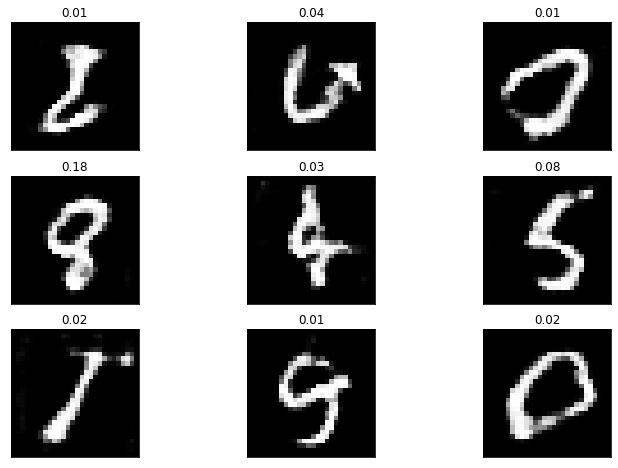

[ 3/10][  1/600] dloss_real=0.4415 dloss_fake=0.3931 gloss=2.4956
[ 3/10][  2/600] dloss_real=0.4785 dloss_fake=0.1198 gloss=2.3742
[ 3/10][  3/600] dloss_real=0.5537 dloss_fake=0.2352 gloss=1.7702
[ 3/10][  4/600] dloss_real=0.4158 dloss_fake=0.3737 gloss=2.7697
[ 3/10][  5/600] dloss_real=0.7499 dloss_fake=0.1491 gloss=1.4260
[ 3/10][  6/600] dloss_real=0.3876 dloss_fake=0.4526 gloss=3.1703
[ 3/10][  7/600] dloss_real=0.6931 dloss_fake=0.0994 gloss=1.4490
[ 3/10][  8/600] dloss_real=0.3892 dloss_fake=0.3794 gloss=2.6339
[ 3/10][  9/600] dloss_real=0.5319 dloss_fake=0.2057 gloss=2.2111
[ 3/10][ 10/600] dloss_real=0.5729 dloss_fake=0.2284 gloss=1.8034
[ 3/10][ 11/600] dloss_real=0.4222 dloss_fake=0.2509 gloss=2.4503
[ 3/10][ 12/600] dloss_real=0.4675 dloss_fake=0.2096 gloss=2.5930
[ 3/10][ 13/600] dloss_real=0.5570 dloss_fake=0.2098 gloss=1.8667
[ 3/10][ 14/600] dloss_real=0.4031 dloss_fake=0.2445 gloss=2.7122
[ 3/10][ 15/600] dloss_real=0.4930 dloss_fake=0.1197 gloss=2.0557
[ 3/10][ 1

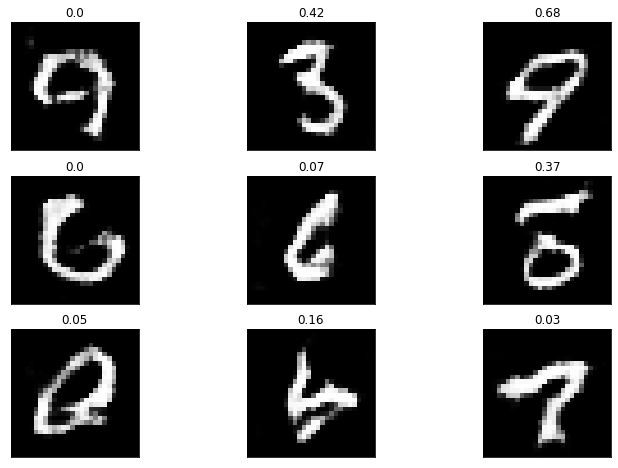

[ 3/10][101/600] dloss_real=0.3771 dloss_fake=0.2962 gloss=3.3779
[ 3/10][102/600] dloss_real=0.7584 dloss_fake=0.0651 gloss=1.5312
[ 3/10][103/600] dloss_real=0.4084 dloss_fake=0.4794 gloss=3.4796
[ 3/10][104/600] dloss_real=0.8800 dloss_fake=0.1029 gloss=1.0711
[ 3/10][105/600] dloss_real=0.3730 dloss_fake=0.4981 gloss=2.7316
[ 3/10][106/600] dloss_real=0.5533 dloss_fake=0.1821 gloss=2.2627
[ 3/10][107/600] dloss_real=0.5691 dloss_fake=0.3042 gloss=1.9413
[ 3/10][108/600] dloss_real=0.4416 dloss_fake=0.2379 gloss=2.3140
[ 3/10][109/600] dloss_real=0.4868 dloss_fake=0.1949 gloss=2.3307
[ 3/10][110/600] dloss_real=0.5037 dloss_fake=0.2441 gloss=2.3206
[ 3/10][111/600] dloss_real=0.5244 dloss_fake=0.1283 gloss=1.9915
[ 3/10][112/600] dloss_real=0.3878 dloss_fake=0.2875 gloss=3.2139
[ 3/10][113/600] dloss_real=0.7314 dloss_fake=0.1139 gloss=0.9402
[ 3/10][114/600] dloss_real=0.3624 dloss_fake=0.8452 gloss=4.3825
[ 3/10][115/600] dloss_real=1.3524 dloss_fake=0.0382 gloss=1.5073
[ 3/10][11

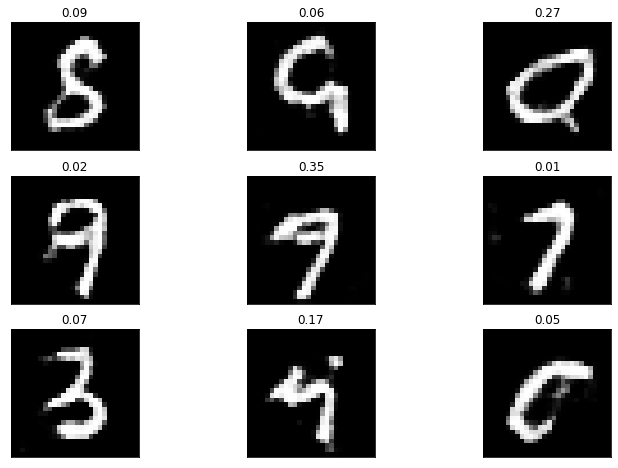

[ 3/10][201/600] dloss_real=0.5672 dloss_fake=0.1811 gloss=1.8364
[ 3/10][202/600] dloss_real=0.4188 dloss_fake=0.2768 gloss=2.6102
[ 3/10][203/600] dloss_real=0.6100 dloss_fake=0.1532 gloss=1.7242
[ 3/10][204/600] dloss_real=0.4028 dloss_fake=0.4016 gloss=2.8865
[ 3/10][205/600] dloss_real=0.6296 dloss_fake=0.0970 gloss=1.7364
[ 3/10][206/600] dloss_real=0.3913 dloss_fake=0.3440 gloss=2.5141
[ 3/10][207/600] dloss_real=0.6134 dloss_fake=0.1592 gloss=1.7056
[ 3/10][208/600] dloss_real=0.3807 dloss_fake=0.3597 gloss=2.6755
[ 3/10][209/600] dloss_real=0.5569 dloss_fake=0.1316 gloss=2.0038
[ 3/10][210/600] dloss_real=0.4158 dloss_fake=0.3363 gloss=2.5648
[ 3/10][211/600] dloss_real=0.5270 dloss_fake=0.1542 gloss=2.1852
[ 3/10][212/600] dloss_real=0.4915 dloss_fake=0.2200 gloss=1.9441
[ 3/10][213/600] dloss_real=0.3749 dloss_fake=0.2520 gloss=3.2613
[ 3/10][214/600] dloss_real=0.6792 dloss_fake=0.0838 gloss=1.3665
[ 3/10][215/600] dloss_real=0.3992 dloss_fake=0.5623 gloss=3.1744
[ 3/10][21

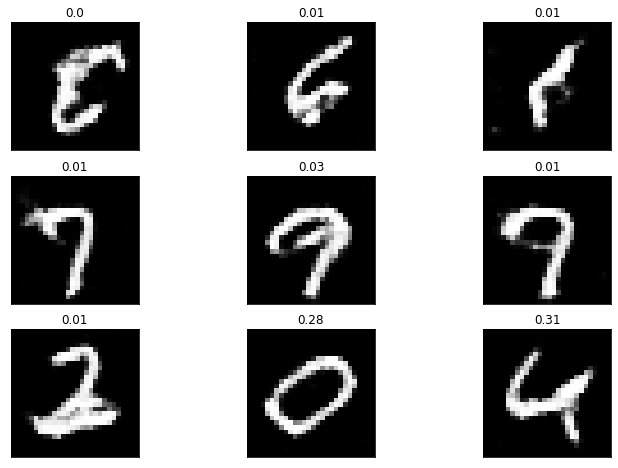

[ 3/10][301/600] dloss_real=0.4555 dloss_fake=0.2350 gloss=2.6992
[ 3/10][302/600] dloss_real=0.5453 dloss_fake=0.1794 gloss=1.8370
[ 3/10][303/600] dloss_real=0.3464 dloss_fake=0.3343 gloss=3.3951
[ 3/10][304/600] dloss_real=0.5987 dloss_fake=0.1090 gloss=1.9791
[ 3/10][305/600] dloss_real=0.4070 dloss_fake=0.1779 gloss=2.1447
[ 3/10][306/600] dloss_real=0.3752 dloss_fake=0.2439 gloss=3.0612
[ 3/10][307/600] dloss_real=0.6718 dloss_fake=0.1045 gloss=1.4820
[ 3/10][308/600] dloss_real=0.4076 dloss_fake=0.4781 gloss=3.2258
[ 3/10][309/600] dloss_real=0.5920 dloss_fake=0.0965 gloss=2.3342
[ 3/10][310/600] dloss_real=0.4594 dloss_fake=0.1959 gloss=2.0058
[ 3/10][311/600] dloss_real=0.4295 dloss_fake=0.3141 gloss=2.8206
[ 3/10][312/600] dloss_real=0.5613 dloss_fake=0.1086 gloss=1.7138
[ 3/10][313/600] dloss_real=0.4223 dloss_fake=0.3292 gloss=2.4985
[ 3/10][314/600] dloss_real=0.4792 dloss_fake=0.2259 gloss=2.4488
[ 3/10][315/600] dloss_real=0.5646 dloss_fake=0.1178 gloss=1.7125
[ 3/10][31

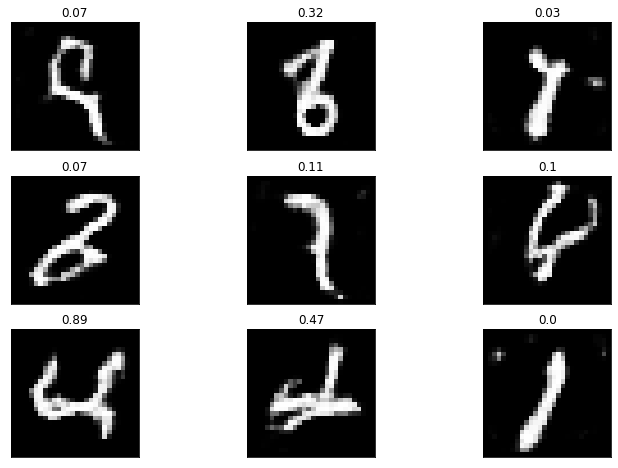

[ 3/10][401/600] dloss_real=0.3925 dloss_fake=0.4727 gloss=2.5103
[ 3/10][402/600] dloss_real=0.5944 dloss_fake=0.1631 gloss=2.0473
[ 3/10][403/600] dloss_real=0.5328 dloss_fake=0.2215 gloss=1.7998
[ 3/10][404/600] dloss_real=0.4137 dloss_fake=0.3530 gloss=2.1870
[ 3/10][405/600] dloss_real=0.5823 dloss_fake=0.2340 gloss=1.7318
[ 3/10][406/600] dloss_real=0.3713 dloss_fake=0.3199 gloss=2.7395
[ 3/10][407/600] dloss_real=0.7933 dloss_fake=0.1723 gloss=1.1893
[ 3/10][408/600] dloss_real=0.3904 dloss_fake=0.6663 gloss=2.9702
[ 3/10][409/600] dloss_real=0.9421 dloss_fake=0.0998 gloss=1.3428
[ 3/10][410/600] dloss_real=0.4251 dloss_fake=0.4356 gloss=2.2165
[ 3/10][411/600] dloss_real=0.4437 dloss_fake=0.3109 gloss=2.9119
[ 3/10][412/600] dloss_real=0.8996 dloss_fake=0.0707 gloss=1.1285
[ 3/10][413/600] dloss_real=0.3681 dloss_fake=0.7905 gloss=3.2143
[ 3/10][414/600] dloss_real=0.6937 dloss_fake=0.0961 gloss=2.2256
[ 3/10][415/600] dloss_real=0.4796 dloss_fake=0.2138 gloss=2.1205
[ 3/10][41

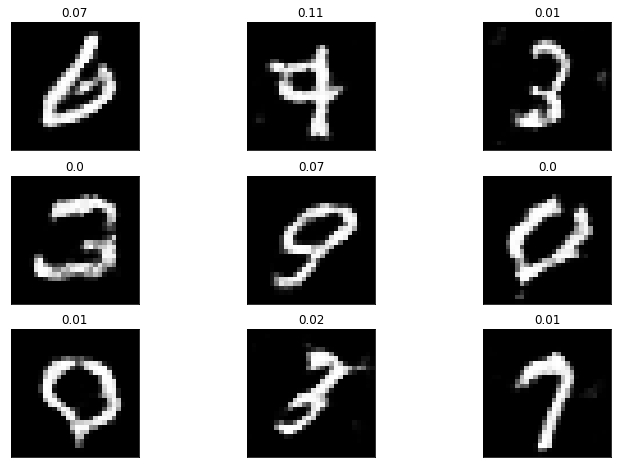

[ 3/10][501/600] dloss_real=0.6980 dloss_fake=0.1491 gloss=1.6179
[ 3/10][502/600] dloss_real=0.4146 dloss_fake=0.5460 gloss=3.0461
[ 3/10][503/600] dloss_real=0.6105 dloss_fake=0.0878 gloss=2.0670
[ 3/10][504/600] dloss_real=0.5758 dloss_fake=0.2875 gloss=1.7952
[ 3/10][505/600] dloss_real=0.3984 dloss_fake=0.3768 gloss=3.1343
[ 3/10][506/600] dloss_real=0.7666 dloss_fake=0.1476 gloss=1.5173
[ 3/10][507/600] dloss_real=0.3991 dloss_fake=0.3253 gloss=2.2352
[ 3/10][508/600] dloss_real=0.5660 dloss_fake=0.2394 gloss=2.0517
[ 3/10][509/600] dloss_real=0.5176 dloss_fake=0.2683 gloss=1.9575
[ 3/10][510/600] dloss_real=0.4509 dloss_fake=0.2290 gloss=2.2753
[ 3/10][511/600] dloss_real=0.4591 dloss_fake=0.2088 gloss=2.7791
[ 3/10][512/600] dloss_real=0.5542 dloss_fake=0.1486 gloss=2.0133
[ 3/10][513/600] dloss_real=0.4319 dloss_fake=0.2156 gloss=2.3587
[ 3/10][514/600] dloss_real=0.5744 dloss_fake=0.2501 gloss=1.5473
[ 3/10][515/600] dloss_real=0.3668 dloss_fake=0.4349 gloss=3.3587
[ 3/10][51

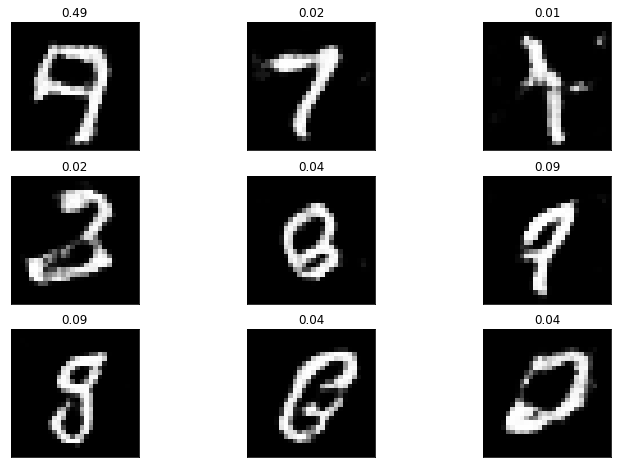

[ 4/10][  1/600] dloss_real=0.4031 dloss_fake=0.3820 gloss=2.9259
[ 4/10][  2/600] dloss_real=0.8209 dloss_fake=0.0825 gloss=1.5900
[ 4/10][  3/600] dloss_real=0.4020 dloss_fake=0.3079 gloss=2.1233
[ 4/10][  4/600] dloss_real=0.4722 dloss_fake=0.2797 gloss=2.6872
[ 4/10][  5/600] dloss_real=0.5646 dloss_fake=0.1785 gloss=1.8993
[ 4/10][  6/600] dloss_real=0.4296 dloss_fake=0.2898 gloss=2.6786
[ 4/10][  7/600] dloss_real=0.5391 dloss_fake=0.1550 gloss=1.9401
[ 4/10][  8/600] dloss_real=0.3730 dloss_fake=0.2305 gloss=2.7183
[ 4/10][  9/600] dloss_real=0.5381 dloss_fake=0.2883 gloss=2.1332
[ 4/10][ 10/600] dloss_real=0.5421 dloss_fake=0.1662 gloss=1.8530
[ 4/10][ 11/600] dloss_real=0.4067 dloss_fake=0.3247 gloss=2.5069
[ 4/10][ 12/600] dloss_real=0.5871 dloss_fake=0.2173 gloss=1.9410
[ 4/10][ 13/600] dloss_real=0.4111 dloss_fake=0.2280 gloss=2.4024
[ 4/10][ 14/600] dloss_real=0.5390 dloss_fake=0.1607 gloss=1.7468
[ 4/10][ 15/600] dloss_real=0.3846 dloss_fake=0.4538 gloss=3.3799
[ 4/10][ 1

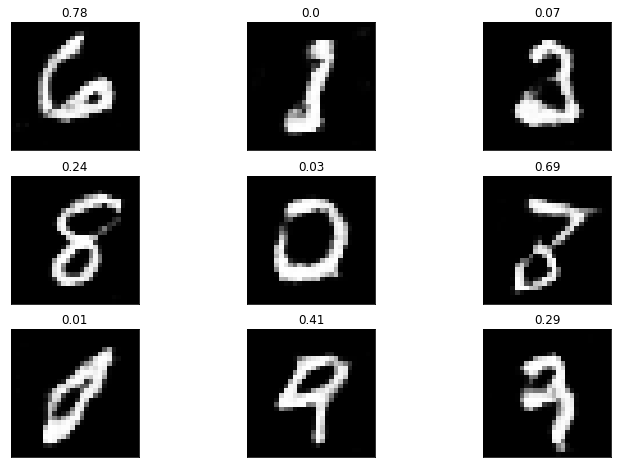

[ 4/10][101/600] dloss_real=0.3492 dloss_fake=0.6094 gloss=3.4945
[ 4/10][102/600] dloss_real=1.1201 dloss_fake=0.0875 gloss=1.1097
[ 4/10][103/600] dloss_real=0.3716 dloss_fake=0.5239 gloss=2.4382
[ 4/10][104/600] dloss_real=0.5047 dloss_fake=0.2447 gloss=2.4676
[ 4/10][105/600] dloss_real=0.6460 dloss_fake=0.1782 gloss=1.5082
[ 4/10][106/600] dloss_real=0.3981 dloss_fake=0.4177 gloss=2.8714
[ 4/10][107/600] dloss_real=0.6923 dloss_fake=0.1586 gloss=1.7614
[ 4/10][108/600] dloss_real=0.4651 dloss_fake=0.3347 gloss=2.3355
[ 4/10][109/600] dloss_real=0.5586 dloss_fake=0.1735 gloss=1.7539
[ 4/10][110/600] dloss_real=0.4041 dloss_fake=0.2859 gloss=2.7748
[ 4/10][111/600] dloss_real=0.5799 dloss_fake=0.1184 gloss=1.7596
[ 4/10][112/600] dloss_real=0.3789 dloss_fake=0.4356 gloss=3.0035
[ 4/10][113/600] dloss_real=0.6079 dloss_fake=0.1028 gloss=2.1607
[ 4/10][114/600] dloss_real=0.4762 dloss_fake=0.2699 gloss=1.8244
[ 4/10][115/600] dloss_real=0.3977 dloss_fake=0.2392 gloss=2.5644
[ 4/10][11

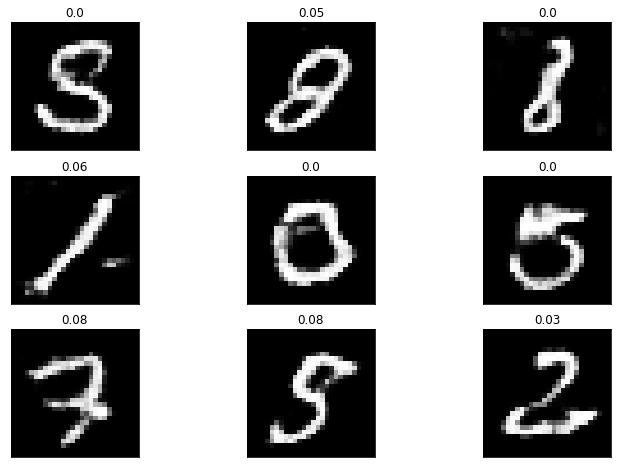

[ 4/10][201/600] dloss_real=0.5366 dloss_fake=0.1940 gloss=2.3497
[ 4/10][202/600] dloss_real=0.4999 dloss_fake=0.1640 gloss=2.0647
[ 4/10][203/600] dloss_real=0.3943 dloss_fake=0.2723 gloss=2.9463
[ 4/10][204/600] dloss_real=0.5862 dloss_fake=0.1887 gloss=1.6012
[ 4/10][205/600] dloss_real=0.4105 dloss_fake=0.3448 gloss=2.7996
[ 4/10][206/600] dloss_real=0.6536 dloss_fake=0.2320 gloss=2.0695
[ 4/10][207/600] dloss_real=0.5306 dloss_fake=0.3268 gloss=1.9558
[ 4/10][208/600] dloss_real=0.4233 dloss_fake=0.1916 gloss=2.6086
[ 4/10][209/600] dloss_real=0.5585 dloss_fake=0.2162 gloss=2.0808
[ 4/10][210/600] dloss_real=0.4660 dloss_fake=0.2526 gloss=2.6081
[ 4/10][211/600] dloss_real=0.5278 dloss_fake=0.1945 gloss=2.1285
[ 4/10][212/600] dloss_real=0.5195 dloss_fake=0.2028 gloss=1.7092
[ 4/10][213/600] dloss_real=0.3827 dloss_fake=0.5011 gloss=3.6804
[ 4/10][214/600] dloss_real=1.2357 dloss_fake=0.0542 gloss=0.8017
[ 4/10][215/600] dloss_real=0.4036 dloss_fake=0.9670 gloss=4.4157
[ 4/10][21

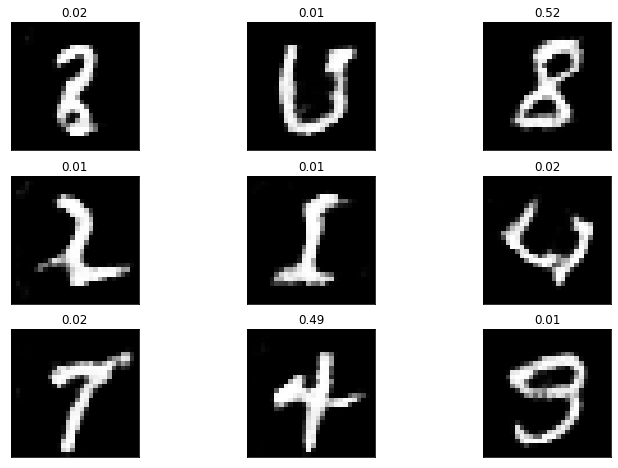

[ 4/10][301/600] dloss_real=0.9069 dloss_fake=0.1307 gloss=0.7970
[ 4/10][302/600] dloss_real=0.3695 dloss_fake=0.7741 gloss=3.2814
[ 4/10][303/600] dloss_real=0.8157 dloss_fake=0.1202 gloss=1.9211
[ 4/10][304/600] dloss_real=0.5144 dloss_fake=0.2839 gloss=1.7112
[ 4/10][305/600] dloss_real=0.4909 dloss_fake=0.5372 gloss=2.2448
[ 4/10][306/600] dloss_real=0.6102 dloss_fake=0.2424 gloss=2.0605
[ 4/10][307/600] dloss_real=0.5707 dloss_fake=0.2110 gloss=1.6720
[ 4/10][308/600] dloss_real=0.4416 dloss_fake=0.3667 gloss=2.2980
[ 4/10][309/600] dloss_real=0.5097 dloss_fake=0.2365 gloss=2.3044
[ 4/10][310/600] dloss_real=0.5603 dloss_fake=0.2565 gloss=1.9272
[ 4/10][311/600] dloss_real=0.4501 dloss_fake=0.1992 gloss=2.1834
[ 4/10][312/600] dloss_real=0.5020 dloss_fake=0.3540 gloss=2.2023
[ 4/10][313/600] dloss_real=0.5750 dloss_fake=0.1712 gloss=1.9607
[ 4/10][314/600] dloss_real=0.4954 dloss_fake=0.3211 gloss=2.1260
[ 4/10][315/600] dloss_real=0.4850 dloss_fake=0.2618 gloss=2.2580
[ 4/10][31

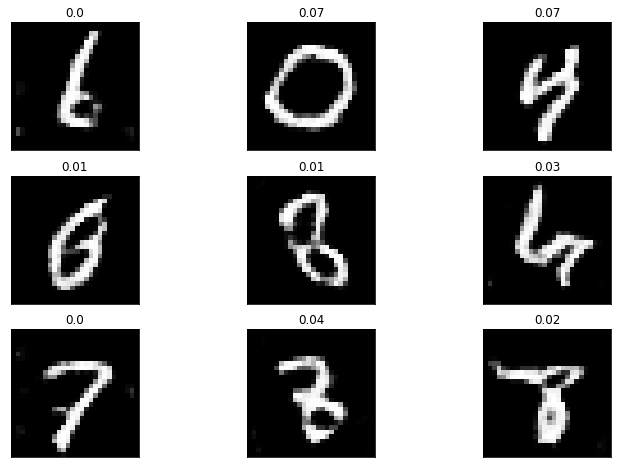

[ 4/10][401/600] dloss_real=0.6477 dloss_fake=0.1404 gloss=1.8358
[ 4/10][402/600] dloss_real=0.4172 dloss_fake=0.3313 gloss=2.5106
[ 4/10][403/600] dloss_real=0.4912 dloss_fake=0.2072 gloss=2.4681
[ 4/10][404/600] dloss_real=0.6278 dloss_fake=0.1736 gloss=1.5624
[ 4/10][405/600] dloss_real=0.3695 dloss_fake=0.4668 gloss=3.3974
[ 4/10][406/600] dloss_real=0.8751 dloss_fake=0.1183 gloss=1.2820
[ 4/10][407/600] dloss_real=0.3788 dloss_fake=0.3489 gloss=2.9067
[ 4/10][408/600] dloss_real=0.6757 dloss_fake=0.2346 gloss=1.6857
[ 4/10][409/600] dloss_real=0.4952 dloss_fake=0.3023 gloss=2.1820
[ 4/10][410/600] dloss_real=0.4045 dloss_fake=0.4127 gloss=2.9578
[ 4/10][411/600] dloss_real=0.7380 dloss_fake=0.1164 gloss=1.6824
[ 4/10][412/600] dloss_real=0.4256 dloss_fake=0.3467 gloss=2.5585
[ 4/10][413/600] dloss_real=0.5488 dloss_fake=0.1369 gloss=1.9583
[ 4/10][414/600] dloss_real=0.4106 dloss_fake=0.5049 gloss=3.1194
[ 4/10][415/600] dloss_real=0.7784 dloss_fake=0.1129 gloss=1.3000
[ 4/10][41

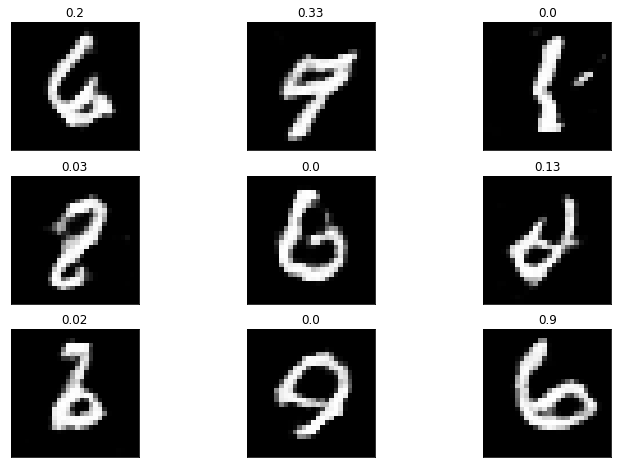

[ 4/10][501/600] dloss_real=0.5328 dloss_fake=0.2052 gloss=2.0564
[ 4/10][502/600] dloss_real=0.3910 dloss_fake=0.3453 gloss=3.3234
[ 4/10][503/600] dloss_real=0.7708 dloss_fake=0.1012 gloss=1.4106
[ 4/10][504/600] dloss_real=0.3892 dloss_fake=0.3823 gloss=2.4803
[ 4/10][505/600] dloss_real=0.5355 dloss_fake=0.1688 gloss=2.1269
[ 4/10][506/600] dloss_real=0.4499 dloss_fake=0.2749 gloss=2.4392
[ 4/10][507/600] dloss_real=0.5381 dloss_fake=0.2132 gloss=2.3972
[ 4/10][508/600] dloss_real=0.4874 dloss_fake=0.1815 gloss=2.1821
[ 4/10][509/600] dloss_real=0.4881 dloss_fake=0.3234 gloss=2.4040
[ 4/10][510/600] dloss_real=0.5670 dloss_fake=0.1960 gloss=1.8766
[ 4/10][511/600] dloss_real=0.4618 dloss_fake=0.2967 gloss=2.5453
[ 4/10][512/600] dloss_real=0.5069 dloss_fake=0.2604 gloss=2.6342
[ 4/10][513/600] dloss_real=0.9260 dloss_fake=0.1263 gloss=0.7845
[ 4/10][514/600] dloss_real=0.4181 dloss_fake=1.0848 gloss=6.4293
[ 4/10][515/600] dloss_real=2.4295 dloss_fake=0.0105 gloss=1.1238
[ 4/10][51

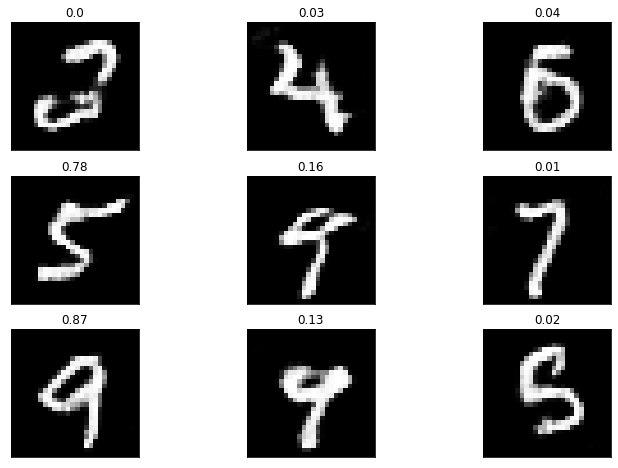

[ 5/10][  1/600] dloss_real=0.3760 dloss_fake=0.3548 gloss=3.0120
[ 5/10][  2/600] dloss_real=0.4951 dloss_fake=0.1485 gloss=2.5308
[ 5/10][  3/600] dloss_real=0.5106 dloss_fake=0.2216 gloss=2.0382
[ 5/10][  4/600] dloss_real=0.4212 dloss_fake=0.2679 gloss=2.4026
[ 5/10][  5/600] dloss_real=0.5645 dloss_fake=0.1906 gloss=1.9529
[ 5/10][  6/600] dloss_real=0.5056 dloss_fake=0.3018 gloss=2.0393
[ 5/10][  7/600] dloss_real=0.4593 dloss_fake=0.2160 gloss=2.3265
[ 5/10][  8/600] dloss_real=0.4667 dloss_fake=0.1968 gloss=2.5434
[ 5/10][  9/600] dloss_real=0.5061 dloss_fake=0.1603 gloss=2.0732
[ 5/10][ 10/600] dloss_real=0.4393 dloss_fake=0.2169 gloss=2.4833
[ 5/10][ 11/600] dloss_real=0.4614 dloss_fake=0.2666 gloss=2.4610
[ 5/10][ 12/600] dloss_real=0.5452 dloss_fake=0.1735 gloss=1.9287
[ 5/10][ 13/600] dloss_real=0.4365 dloss_fake=0.2050 gloss=2.5967
[ 5/10][ 14/600] dloss_real=0.4452 dloss_fake=0.2136 gloss=2.4517
[ 5/10][ 15/600] dloss_real=0.5620 dloss_fake=0.1260 gloss=1.6209
[ 5/10][ 1

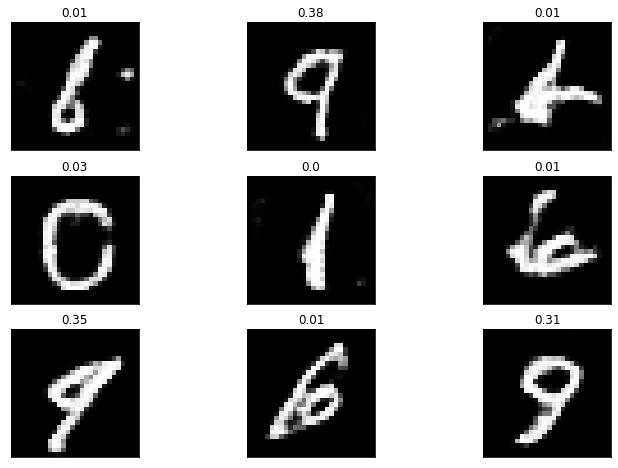

[ 5/10][101/600] dloss_real=0.5087 dloss_fake=0.2567 gloss=2.1379
[ 5/10][102/600] dloss_real=0.4733 dloss_fake=0.3095 gloss=2.3884
[ 5/10][103/600] dloss_real=0.5144 dloss_fake=0.1785 gloss=1.9954
[ 5/10][104/600] dloss_real=0.4650 dloss_fake=0.2381 gloss=2.0988
[ 5/10][105/600] dloss_real=0.4251 dloss_fake=0.3518 gloss=2.6495
[ 5/10][106/600] dloss_real=0.5833 dloss_fake=0.1782 gloss=2.0515
[ 5/10][107/600] dloss_real=0.5238 dloss_fake=0.3187 gloss=1.8917
[ 5/10][108/600] dloss_real=0.5178 dloss_fake=0.2767 gloss=2.3506
[ 5/10][109/600] dloss_real=0.4918 dloss_fake=0.2437 gloss=2.2822
[ 5/10][110/600] dloss_real=0.4863 dloss_fake=0.1445 gloss=2.1376
[ 5/10][111/600] dloss_real=0.4482 dloss_fake=0.4166 gloss=2.8295
[ 5/10][112/600] dloss_real=0.7608 dloss_fake=0.1721 gloss=1.3264
[ 5/10][113/600] dloss_real=0.4157 dloss_fake=0.3520 gloss=2.6905
[ 5/10][114/600] dloss_real=0.5128 dloss_fake=0.2943 gloss=2.5820
[ 5/10][115/600] dloss_real=0.8046 dloss_fake=0.1306 gloss=0.9698
[ 5/10][11

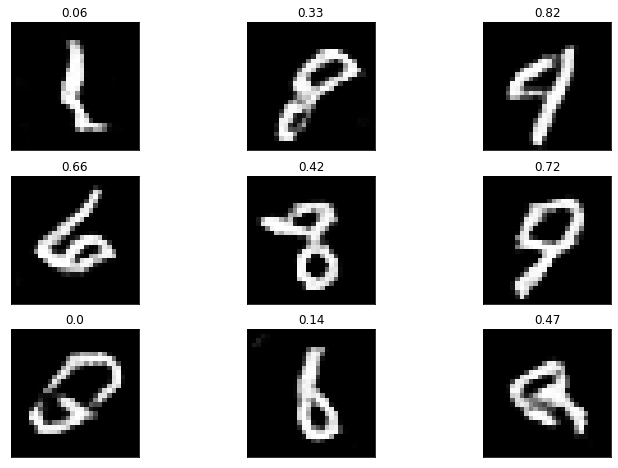

[ 5/10][201/600] dloss_real=0.3433 dloss_fake=0.5432 gloss=3.8168
[ 5/10][202/600] dloss_real=0.9757 dloss_fake=0.1119 gloss=1.0077
[ 5/10][203/600] dloss_real=0.3438 dloss_fake=0.7613 gloss=3.6718
[ 5/10][204/600] dloss_real=1.1387 dloss_fake=0.0727 gloss=1.3018
[ 5/10][205/600] dloss_real=0.3767 dloss_fake=0.5218 gloss=2.3372
[ 5/10][206/600] dloss_real=0.5347 dloss_fake=0.1852 gloss=2.2278
[ 5/10][207/600] dloss_real=0.5769 dloss_fake=0.2145 gloss=1.6763
[ 5/10][208/600] dloss_real=0.4465 dloss_fake=0.3432 gloss=2.2755
[ 5/10][209/600] dloss_real=0.4911 dloss_fake=0.2318 gloss=2.2951
[ 5/10][210/600] dloss_real=0.4941 dloss_fake=0.1627 gloss=1.9957
[ 5/10][211/600] dloss_real=0.4632 dloss_fake=0.3807 gloss=2.4222
[ 5/10][212/600] dloss_real=0.5055 dloss_fake=0.1327 gloss=2.3077
[ 5/10][213/600] dloss_real=0.4638 dloss_fake=0.3767 gloss=2.3526
[ 5/10][214/600] dloss_real=0.5409 dloss_fake=0.1643 gloss=2.2239
[ 5/10][215/600] dloss_real=0.5245 dloss_fake=0.1980 gloss=1.9268
[ 5/10][21

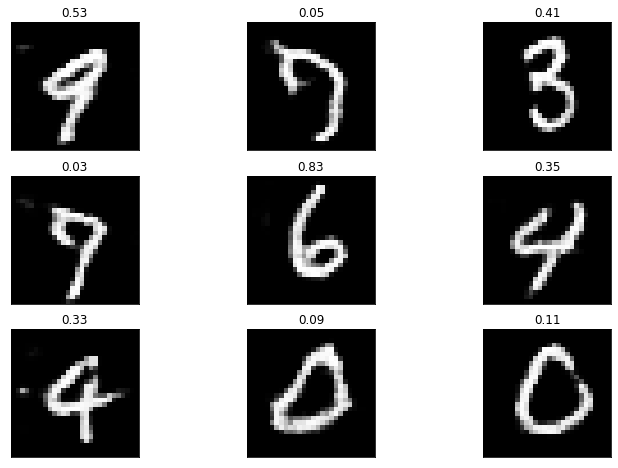

[ 5/10][301/600] dloss_real=0.3846 dloss_fake=0.4328 gloss=3.5333
[ 5/10][302/600] dloss_real=0.7373 dloss_fake=0.0813 gloss=1.8467
[ 5/10][303/600] dloss_real=0.4078 dloss_fake=0.3956 gloss=2.5843
[ 5/10][304/600] dloss_real=0.5935 dloss_fake=0.1486 gloss=1.9760
[ 5/10][305/600] dloss_real=0.5040 dloss_fake=0.3036 gloss=2.5617
[ 5/10][306/600] dloss_real=0.5032 dloss_fake=0.2090 gloss=2.3251
[ 5/10][307/600] dloss_real=0.4240 dloss_fake=0.1975 gloss=2.7552
[ 5/10][308/600] dloss_real=0.5386 dloss_fake=0.1378 gloss=1.8398
[ 5/10][309/600] dloss_real=0.4775 dloss_fake=0.4758 gloss=2.7623
[ 5/10][310/600] dloss_real=0.6185 dloss_fake=0.1879 gloss=1.9960
[ 5/10][311/600] dloss_real=0.4089 dloss_fake=0.2906 gloss=2.9740
[ 5/10][312/600] dloss_real=0.5578 dloss_fake=0.1178 gloss=1.9108
[ 5/10][313/600] dloss_real=0.3974 dloss_fake=0.3562 gloss=3.3345
[ 5/10][314/600] dloss_real=0.9676 dloss_fake=0.1384 gloss=0.8777
[ 5/10][315/600] dloss_real=0.3723 dloss_fake=0.4613 gloss=3.5644
[ 5/10][31

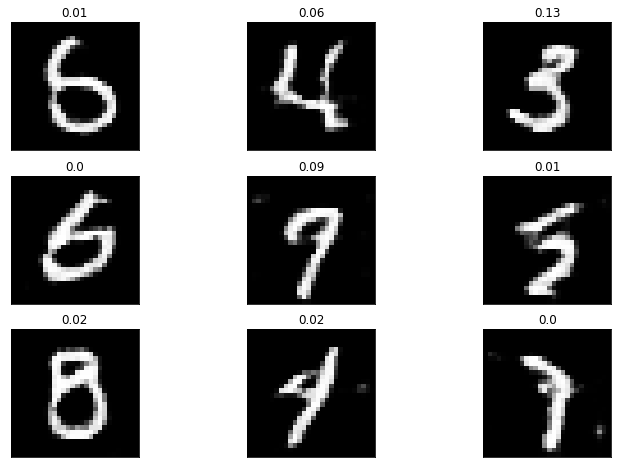

[ 5/10][401/600] dloss_real=0.5482 dloss_fake=0.2022 gloss=2.1092
[ 5/10][402/600] dloss_real=0.5366 dloss_fake=0.2623 gloss=1.8713
[ 5/10][403/600] dloss_real=0.4393 dloss_fake=0.3479 gloss=2.8678
[ 5/10][404/600] dloss_real=0.5711 dloss_fake=0.2648 gloss=2.1984
[ 5/10][405/600] dloss_real=0.6180 dloss_fake=0.1133 gloss=1.4342
[ 5/10][406/600] dloss_real=0.3871 dloss_fake=0.6931 gloss=3.7398
[ 5/10][407/600] dloss_real=1.0197 dloss_fake=0.0767 gloss=1.3945
[ 5/10][408/600] dloss_real=0.4139 dloss_fake=0.4106 gloss=2.2195
[ 5/10][409/600] dloss_real=0.4808 dloss_fake=0.2348 gloss=2.5586
[ 5/10][410/600] dloss_real=0.5556 dloss_fake=0.1651 gloss=1.9682
[ 5/10][411/600] dloss_real=0.4532 dloss_fake=0.2591 gloss=2.1244
[ 5/10][412/600] dloss_real=0.4082 dloss_fake=0.2784 gloss=2.7344
[ 5/10][413/600] dloss_real=0.6180 dloss_fake=0.1609 gloss=1.7240
[ 5/10][414/600] dloss_real=0.4381 dloss_fake=0.2997 gloss=2.1223
[ 5/10][415/600] dloss_real=0.3916 dloss_fake=0.2073 gloss=3.2923
[ 5/10][41

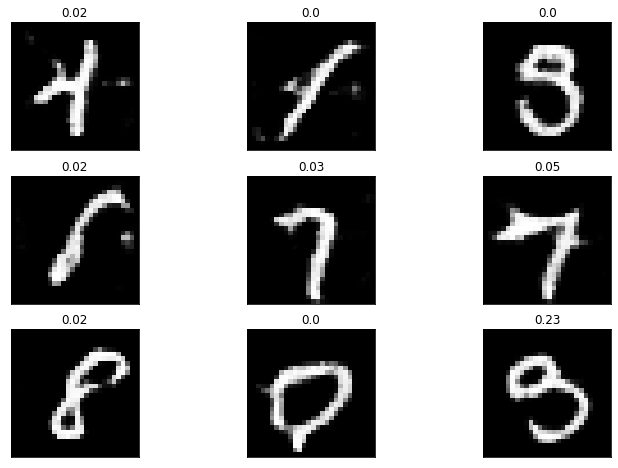

[ 5/10][501/600] dloss_real=0.5953 dloss_fake=0.1812 gloss=1.7375
[ 5/10][502/600] dloss_real=0.3649 dloss_fake=0.4674 gloss=3.5871
[ 5/10][503/600] dloss_real=0.9713 dloss_fake=0.0394 gloss=1.2600
[ 5/10][504/600] dloss_real=0.3852 dloss_fake=0.3959 gloss=2.2517
[ 5/10][505/600] dloss_real=0.5041 dloss_fake=0.3208 gloss=2.3043
[ 5/10][506/600] dloss_real=0.5274 dloss_fake=0.2927 gloss=2.2047
[ 5/10][507/600] dloss_real=0.7050 dloss_fake=0.2172 gloss=1.4336
[ 5/10][508/600] dloss_real=0.4091 dloss_fake=0.5584 gloss=2.8315
[ 5/10][509/600] dloss_real=0.7067 dloss_fake=0.1553 gloss=2.0242
[ 5/10][510/600] dloss_real=0.3916 dloss_fake=0.2124 gloss=2.3346
[ 5/10][511/600] dloss_real=0.5519 dloss_fake=0.3285 gloss=2.0024
[ 5/10][512/600] dloss_real=0.4335 dloss_fake=0.2056 gloss=2.6032
[ 5/10][513/600] dloss_real=0.5297 dloss_fake=0.2658 gloss=2.0188
[ 5/10][514/600] dloss_real=0.4736 dloss_fake=0.3557 gloss=2.7155
[ 5/10][515/600] dloss_real=0.7620 dloss_fake=0.1800 gloss=1.0544
[ 5/10][51

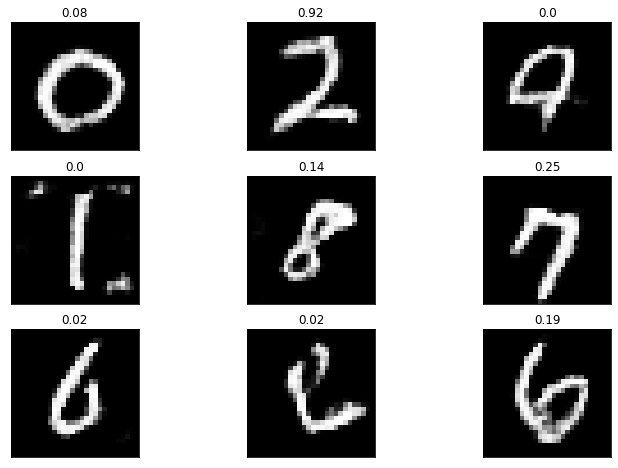

[ 6/10][  1/600] dloss_real=0.5317 dloss_fake=0.2828 gloss=1.8187
[ 6/10][  2/600] dloss_real=0.4149 dloss_fake=0.2614 gloss=2.4889
[ 6/10][  3/600] dloss_real=0.5204 dloss_fake=0.2648 gloss=2.2817
[ 6/10][  4/600] dloss_real=0.5642 dloss_fake=0.1505 gloss=1.7012
[ 6/10][  5/600] dloss_real=0.3688 dloss_fake=0.4586 gloss=3.4014
[ 6/10][  6/600] dloss_real=0.8683 dloss_fake=0.1093 gloss=1.3789
[ 6/10][  7/600] dloss_real=0.3803 dloss_fake=0.5379 gloss=3.2735
[ 6/10][  8/600] dloss_real=0.7278 dloss_fake=0.0791 gloss=1.6886
[ 6/10][  9/600] dloss_real=0.4230 dloss_fake=0.3730 gloss=2.2652
[ 6/10][ 10/600] dloss_real=0.4887 dloss_fake=0.2421 gloss=2.2162
[ 6/10][ 11/600] dloss_real=0.4891 dloss_fake=0.2639 gloss=2.2716
[ 6/10][ 12/600] dloss_real=0.5286 dloss_fake=0.1962 gloss=1.8514
[ 6/10][ 13/600] dloss_real=0.4196 dloss_fake=0.3635 gloss=2.7306
[ 6/10][ 14/600] dloss_real=0.6538 dloss_fake=0.1174 gloss=1.6079
[ 6/10][ 15/600] dloss_real=0.4860 dloss_fake=0.3550 gloss=2.1537
[ 6/10][ 1

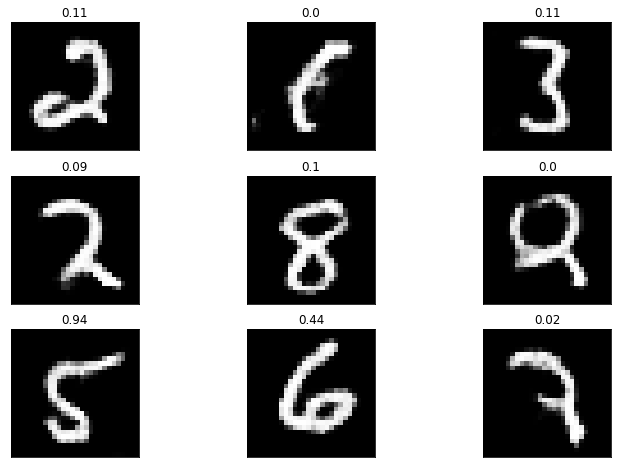

[ 6/10][101/600] dloss_real=0.7138 dloss_fake=0.1943 gloss=1.6879
[ 6/10][102/600] dloss_real=0.4130 dloss_fake=0.3791 gloss=2.6684
[ 6/10][103/600] dloss_real=0.6649 dloss_fake=0.1877 gloss=1.7469
[ 6/10][104/600] dloss_real=0.4528 dloss_fake=0.3333 gloss=2.3169
[ 6/10][105/600] dloss_real=0.4720 dloss_fake=0.2879 gloss=2.4538
[ 6/10][106/600] dloss_real=0.5325 dloss_fake=0.1796 gloss=2.0396
[ 6/10][107/600] dloss_real=0.4920 dloss_fake=0.2155 gloss=2.0517
[ 6/10][108/600] dloss_real=0.4223 dloss_fake=0.1969 gloss=2.4665
[ 6/10][109/600] dloss_real=0.4712 dloss_fake=0.2599 gloss=2.2663
[ 6/10][110/600] dloss_real=0.4279 dloss_fake=0.2348 gloss=2.7682
[ 6/10][111/600] dloss_real=0.7287 dloss_fake=0.1300 gloss=1.1776
[ 6/10][112/600] dloss_real=0.3836 dloss_fake=0.6266 gloss=3.6558
[ 6/10][113/600] dloss_real=0.6855 dloss_fake=0.0559 gloss=2.4757
[ 6/10][114/600] dloss_real=0.4983 dloss_fake=0.2489 gloss=1.8087
[ 6/10][115/600] dloss_real=0.4530 dloss_fake=0.2663 gloss=2.4893
[ 6/10][11

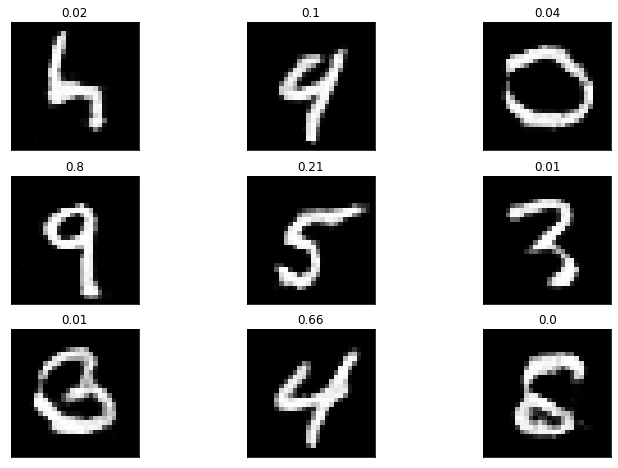

[ 6/10][201/600] dloss_real=0.5397 dloss_fake=0.2437 gloss=1.9523
[ 6/10][202/600] dloss_real=0.4126 dloss_fake=0.2114 gloss=2.4203
[ 6/10][203/600] dloss_real=0.4677 dloss_fake=0.1933 gloss=2.0275
[ 6/10][204/600] dloss_real=0.4170 dloss_fake=0.4667 gloss=3.1134
[ 6/10][205/600] dloss_real=0.8035 dloss_fake=0.0835 gloss=1.4821
[ 6/10][206/600] dloss_real=0.4209 dloss_fake=0.3914 gloss=2.2972
[ 6/10][207/600] dloss_real=0.4113 dloss_fake=0.2223 gloss=3.2384
[ 6/10][208/600] dloss_real=0.7421 dloss_fake=0.1618 gloss=1.2899
[ 6/10][209/600] dloss_real=0.4012 dloss_fake=0.4462 gloss=3.2355
[ 6/10][210/600] dloss_real=0.6814 dloss_fake=0.1245 gloss=2.0781
[ 6/10][211/600] dloss_real=0.4709 dloss_fake=0.3497 gloss=2.0512
[ 6/10][212/600] dloss_real=0.4816 dloss_fake=0.2440 gloss=2.2743
[ 6/10][213/600] dloss_real=0.4308 dloss_fake=0.2706 gloss=2.5933
[ 6/10][214/600] dloss_real=0.5705 dloss_fake=0.2177 gloss=2.0856
[ 6/10][215/600] dloss_real=0.4838 dloss_fake=0.2643 gloss=2.1237
[ 6/10][21

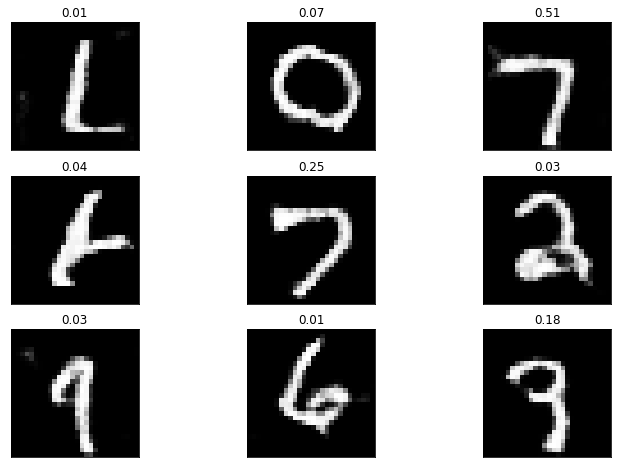

[ 6/10][301/600] dloss_real=0.3939 dloss_fake=0.3138 gloss=2.9722
[ 6/10][302/600] dloss_real=0.6448 dloss_fake=0.1572 gloss=1.9427
[ 6/10][303/600] dloss_real=0.4913 dloss_fake=0.2001 gloss=1.9503
[ 6/10][304/600] dloss_real=0.5187 dloss_fake=0.3174 gloss=2.1458
[ 6/10][305/600] dloss_real=0.4604 dloss_fake=0.2207 gloss=2.6098
[ 6/10][306/600] dloss_real=0.5409 dloss_fake=0.1761 gloss=1.9978
[ 6/10][307/600] dloss_real=0.4662 dloss_fake=0.2926 gloss=2.3890
[ 6/10][308/600] dloss_real=0.4787 dloss_fake=0.2185 gloss=2.4984
[ 6/10][309/600] dloss_real=0.4723 dloss_fake=0.1661 gloss=2.1883
[ 6/10][310/600] dloss_real=0.4512 dloss_fake=0.3504 gloss=2.7265
[ 6/10][311/600] dloss_real=0.6084 dloss_fake=0.1692 gloss=1.5412
[ 6/10][312/600] dloss_real=0.3922 dloss_fake=0.3968 gloss=2.9399
[ 6/10][313/600] dloss_real=0.5528 dloss_fake=0.1872 gloss=2.3326
[ 6/10][314/600] dloss_real=0.5447 dloss_fake=0.1909 gloss=1.6724
[ 6/10][315/600] dloss_real=0.3836 dloss_fake=0.4177 gloss=2.8663
[ 6/10][31

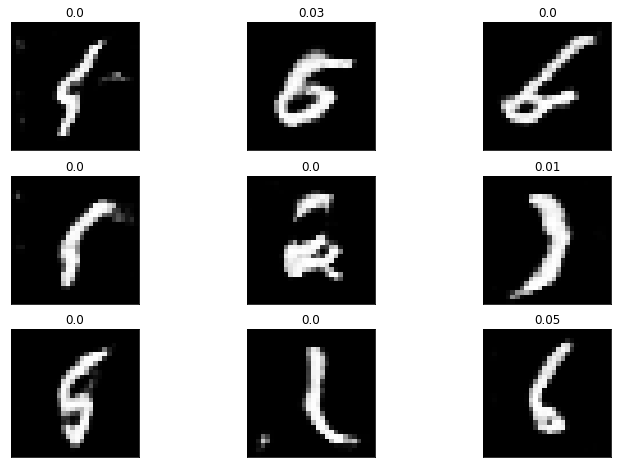

[ 6/10][401/600] dloss_real=0.8688 dloss_fake=0.1480 gloss=1.2686
[ 6/10][402/600] dloss_real=0.3722 dloss_fake=0.4405 gloss=2.9329
[ 6/10][403/600] dloss_real=0.8227 dloss_fake=0.1908 gloss=1.3699
[ 6/10][404/600] dloss_real=0.4059 dloss_fake=0.7326 gloss=3.0425
[ 6/10][405/600] dloss_real=1.0955 dloss_fake=0.0697 gloss=1.0317
[ 6/10][406/600] dloss_real=0.3975 dloss_fake=0.9077 gloss=3.1593
[ 6/10][407/600] dloss_real=0.6719 dloss_fake=0.1595 gloss=2.3295
[ 6/10][408/600] dloss_real=0.5621 dloss_fake=0.1171 gloss=1.6778
[ 6/10][409/600] dloss_real=0.4157 dloss_fake=0.3181 gloss=2.4723
[ 6/10][410/600] dloss_real=0.4856 dloss_fake=0.2650 gloss=2.3933
[ 6/10][411/600] dloss_real=0.5317 dloss_fake=0.2881 gloss=2.0194
[ 6/10][412/600] dloss_real=0.4752 dloss_fake=0.2815 gloss=2.2851
[ 6/10][413/600] dloss_real=0.5014 dloss_fake=0.2479 gloss=2.3163
[ 6/10][414/600] dloss_real=0.4863 dloss_fake=0.2284 gloss=2.1694
[ 6/10][415/600] dloss_real=0.5095 dloss_fake=0.1727 gloss=1.9166
[ 6/10][41

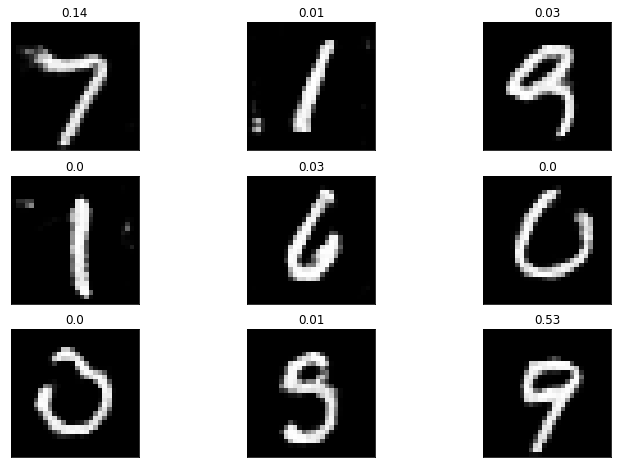

[ 6/10][501/600] dloss_real=0.5259 dloss_fake=0.1791 gloss=2.1699
[ 6/10][502/600] dloss_real=0.4981 dloss_fake=0.2669 gloss=1.9309
[ 6/10][503/600] dloss_real=0.4567 dloss_fake=0.3519 gloss=2.4265
[ 6/10][504/600] dloss_real=0.5584 dloss_fake=0.1677 gloss=2.0894
[ 6/10][505/600] dloss_real=0.4558 dloss_fake=0.2111 gloss=2.2034
[ 6/10][506/600] dloss_real=0.3999 dloss_fake=0.3009 gloss=2.9953
[ 6/10][507/600] dloss_real=0.6455 dloss_fake=0.1783 gloss=1.7713
[ 6/10][508/600] dloss_real=0.3866 dloss_fake=0.3448 gloss=2.9499
[ 6/10][509/600] dloss_real=0.6743 dloss_fake=0.1245 gloss=1.7885
[ 6/10][510/600] dloss_real=0.4068 dloss_fake=0.3721 gloss=2.8761
[ 6/10][511/600] dloss_real=0.6435 dloss_fake=0.1619 gloss=1.8515
[ 6/10][512/600] dloss_real=0.4658 dloss_fake=0.1823 gloss=1.9935
[ 6/10][513/600] dloss_real=0.3937 dloss_fake=0.3941 gloss=3.8368
[ 6/10][514/600] dloss_real=0.9617 dloss_fake=0.0741 gloss=1.3803
[ 6/10][515/600] dloss_real=0.4087 dloss_fake=0.5271 gloss=2.6075
[ 6/10][51

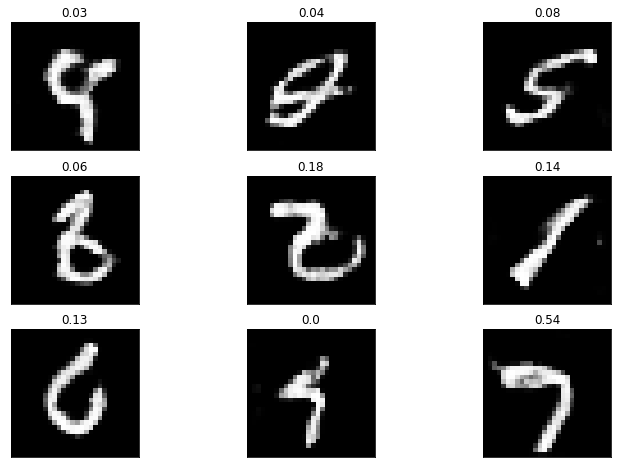

[ 7/10][  1/600] dloss_real=0.3758 dloss_fake=0.9038 gloss=3.7648
[ 7/10][  2/600] dloss_real=0.9621 dloss_fake=0.1135 gloss=1.7584
[ 7/10][  3/600] dloss_real=0.5385 dloss_fake=0.2383 gloss=1.5703
[ 7/10][  4/600] dloss_real=0.3788 dloss_fake=0.4601 gloss=3.0902
[ 7/10][  5/600] dloss_real=0.6867 dloss_fake=0.1826 gloss=1.5495
[ 7/10][  6/600] dloss_real=0.5463 dloss_fake=0.3148 gloss=1.9292
[ 7/10][  7/600] dloss_real=0.4591 dloss_fake=0.3068 gloss=2.3218
[ 7/10][  8/600] dloss_real=0.4373 dloss_fake=0.2025 gloss=2.5689
[ 7/10][  9/600] dloss_real=0.5761 dloss_fake=0.1554 gloss=1.6996
[ 7/10][ 10/600] dloss_real=0.3836 dloss_fake=0.3875 gloss=3.0463
[ 7/10][ 11/600] dloss_real=0.5603 dloss_fake=0.1012 gloss=2.2344
[ 7/10][ 12/600] dloss_real=0.4742 dloss_fake=0.1878 gloss=2.1189
[ 7/10][ 13/600] dloss_real=0.4143 dloss_fake=0.4920 gloss=3.2273
[ 7/10][ 14/600] dloss_real=0.6375 dloss_fake=0.0698 gloss=2.1920
[ 7/10][ 15/600] dloss_real=0.5734 dloss_fake=0.3418 gloss=1.5721
[ 7/10][ 1

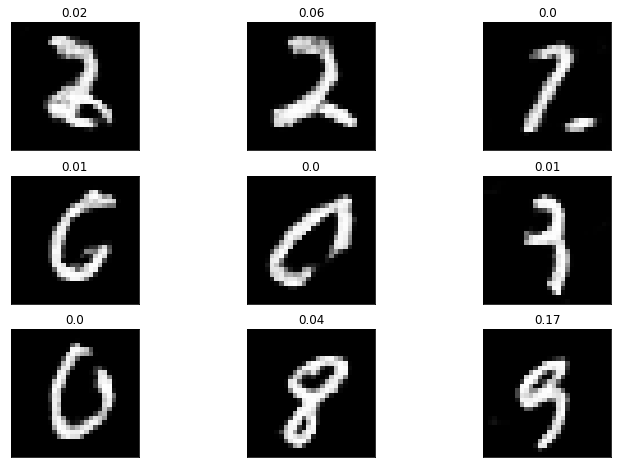

[ 7/10][101/600] dloss_real=0.7388 dloss_fake=0.1121 gloss=1.4581
[ 7/10][102/600] dloss_real=0.4084 dloss_fake=0.4801 gloss=2.3905
[ 7/10][103/600] dloss_real=0.4424 dloss_fake=0.2047 gloss=3.1579
[ 7/10][104/600] dloss_real=0.7537 dloss_fake=0.1262 gloss=1.3100
[ 7/10][105/600] dloss_real=0.4223 dloss_fake=0.5627 gloss=3.0610
[ 7/10][106/600] dloss_real=0.7042 dloss_fake=0.1383 gloss=1.8793
[ 7/10][107/600] dloss_real=0.5542 dloss_fake=0.2250 gloss=1.7049
[ 7/10][108/600] dloss_real=0.3942 dloss_fake=0.3822 gloss=3.5298
[ 7/10][109/600] dloss_real=0.7087 dloss_fake=0.1457 gloss=1.7838
[ 7/10][110/600] dloss_real=0.4159 dloss_fake=0.3305 gloss=2.6697
[ 7/10][111/600] dloss_real=0.5264 dloss_fake=0.2015 gloss=2.2900
[ 7/10][112/600] dloss_real=0.5628 dloss_fake=0.1787 gloss=1.7575
[ 7/10][113/600] dloss_real=0.4074 dloss_fake=0.4264 gloss=2.6197
[ 7/10][114/600] dloss_real=0.4526 dloss_fake=0.2169 gloss=3.0119
[ 7/10][115/600] dloss_real=0.7499 dloss_fake=0.1484 gloss=1.2495
[ 7/10][11

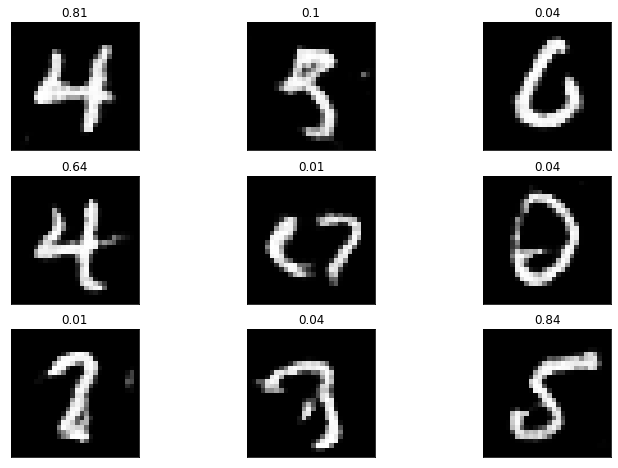

[ 7/10][201/600] dloss_real=0.3894 dloss_fake=0.7877 gloss=3.0375
[ 7/10][202/600] dloss_real=0.6932 dloss_fake=0.1468 gloss=2.1274
[ 7/10][203/600] dloss_real=0.5256 dloss_fake=0.2139 gloss=1.7871
[ 7/10][204/600] dloss_real=0.4391 dloss_fake=0.3141 gloss=2.2771
[ 7/10][205/600] dloss_real=0.5522 dloss_fake=0.2600 gloss=2.0378
[ 7/10][206/600] dloss_real=0.4955 dloss_fake=0.2941 gloss=2.1384
[ 7/10][207/600] dloss_real=0.6144 dloss_fake=0.1641 gloss=1.8243
[ 7/10][208/600] dloss_real=0.4025 dloss_fake=0.4240 gloss=2.6311
[ 7/10][209/600] dloss_real=0.5701 dloss_fake=0.1637 gloss=2.1463
[ 7/10][210/600] dloss_real=0.4819 dloss_fake=0.2323 gloss=2.1723
[ 7/10][211/600] dloss_real=0.4470 dloss_fake=0.2037 gloss=2.2084
[ 7/10][212/600] dloss_real=0.5550 dloss_fake=0.2925 gloss=1.8335
[ 7/10][213/600] dloss_real=0.5545 dloss_fake=0.2611 gloss=1.9156
[ 7/10][214/600] dloss_real=0.4324 dloss_fake=0.2796 gloss=2.4000
[ 7/10][215/600] dloss_real=0.4911 dloss_fake=0.3775 gloss=2.6129
[ 7/10][21

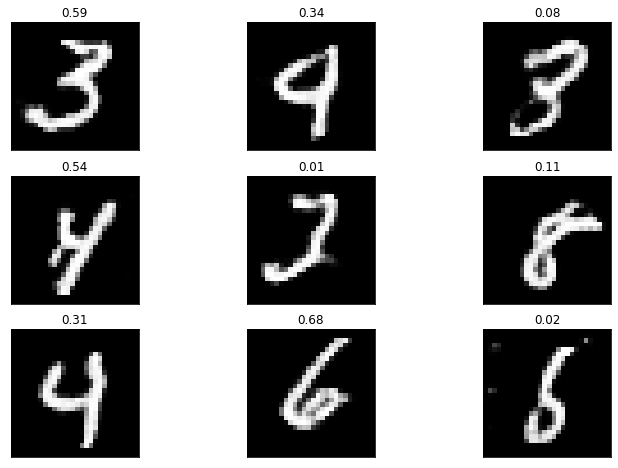

[ 7/10][301/600] dloss_real=0.3600 dloss_fake=0.6217 gloss=3.4625
[ 7/10][302/600] dloss_real=0.6825 dloss_fake=0.1482 gloss=2.1229
[ 7/10][303/600] dloss_real=0.5410 dloss_fake=0.1786 gloss=1.9127
[ 7/10][304/600] dloss_real=0.4122 dloss_fake=0.4644 gloss=3.1500
[ 7/10][305/600] dloss_real=0.6304 dloss_fake=0.1129 gloss=2.0002
[ 7/10][306/600] dloss_real=0.4404 dloss_fake=0.2336 gloss=2.1754
[ 7/10][307/600] dloss_real=0.3964 dloss_fake=0.3212 gloss=3.0252
[ 7/10][308/600] dloss_real=0.6857 dloss_fake=0.1178 gloss=1.7489
[ 7/10][309/600] dloss_real=0.4917 dloss_fake=0.2763 gloss=2.0283
[ 7/10][310/600] dloss_real=0.4145 dloss_fake=0.2905 gloss=3.0130
[ 7/10][311/600] dloss_real=0.5592 dloss_fake=0.1370 gloss=2.1568
[ 7/10][312/600] dloss_real=0.5728 dloss_fake=0.1852 gloss=1.7173
[ 7/10][313/600] dloss_real=0.3906 dloss_fake=0.7493 gloss=4.2485
[ 7/10][314/600] dloss_real=1.6003 dloss_fake=0.0377 gloss=1.1053
[ 7/10][315/600] dloss_real=0.4070 dloss_fake=0.8151 gloss=3.3781
[ 7/10][31

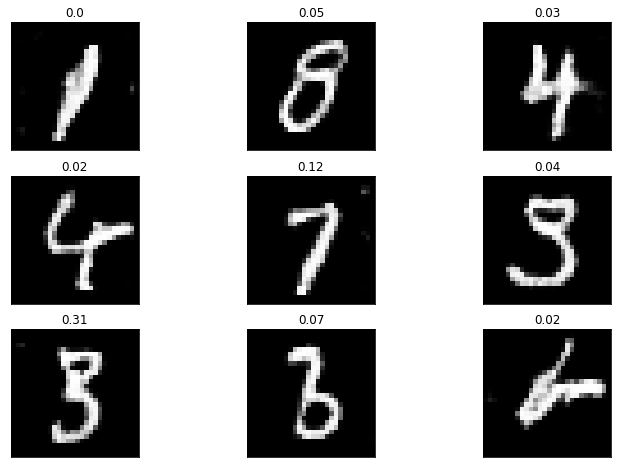

[ 7/10][401/600] dloss_real=0.4141 dloss_fake=0.4245 gloss=3.0121
[ 7/10][402/600] dloss_real=0.7411 dloss_fake=0.1456 gloss=1.5726
[ 7/10][403/600] dloss_real=0.4356 dloss_fake=0.3684 gloss=2.5210
[ 7/10][404/600] dloss_real=0.4792 dloss_fake=0.2335 gloss=2.5996
[ 7/10][405/600] dloss_real=0.5948 dloss_fake=0.1431 gloss=1.6681
[ 7/10][406/600] dloss_real=0.4385 dloss_fake=0.3531 gloss=2.5466
[ 7/10][407/600] dloss_real=0.5762 dloss_fake=0.1898 gloss=2.2570
[ 7/10][408/600] dloss_real=0.4376 dloss_fake=0.3015 gloss=2.6528
[ 7/10][409/600] dloss_real=0.5996 dloss_fake=0.2719 gloss=1.8517
[ 7/10][410/600] dloss_real=0.4708 dloss_fake=0.2748 gloss=2.2787
[ 7/10][411/600] dloss_real=0.4210 dloss_fake=0.2566 gloss=2.7039
[ 7/10][412/600] dloss_real=0.6275 dloss_fake=0.2683 gloss=1.8338
[ 7/10][413/600] dloss_real=0.5312 dloss_fake=0.3267 gloss=2.3836
[ 7/10][414/600] dloss_real=0.5028 dloss_fake=0.1874 gloss=2.3599
[ 7/10][415/600] dloss_real=0.3811 dloss_fake=0.3373 gloss=3.0430
[ 7/10][41

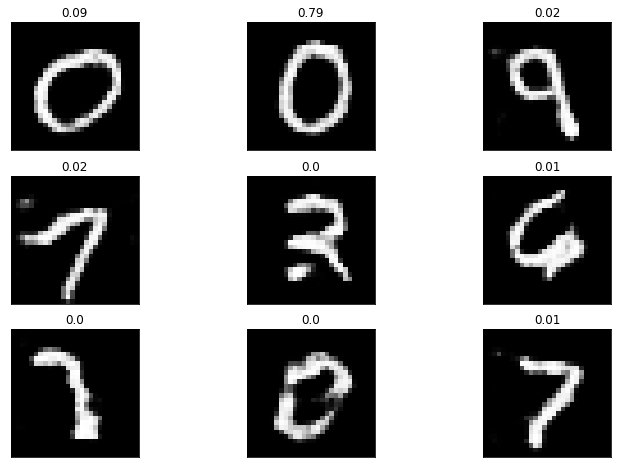

[ 7/10][501/600] dloss_real=0.9633 dloss_fake=0.0862 gloss=1.4206
[ 7/10][502/600] dloss_real=0.3673 dloss_fake=0.6023 gloss=3.2188
[ 7/10][503/600] dloss_real=0.6943 dloss_fake=0.1294 gloss=2.1088
[ 7/10][504/600] dloss_real=0.5278 dloss_fake=0.3423 gloss=1.9143
[ 7/10][505/600] dloss_real=0.4755 dloss_fake=0.3239 gloss=2.2275
[ 7/10][506/600] dloss_real=0.4690 dloss_fake=0.1819 gloss=2.2916
[ 7/10][507/600] dloss_real=0.4999 dloss_fake=0.1879 gloss=2.0804
[ 7/10][508/600] dloss_real=0.4375 dloss_fake=0.2877 gloss=2.5352
[ 7/10][509/600] dloss_real=0.5691 dloss_fake=0.1506 gloss=1.9914
[ 7/10][510/600] dloss_real=0.4642 dloss_fake=0.4032 gloss=2.1672
[ 7/10][511/600] dloss_real=0.4624 dloss_fake=0.2618 gloss=2.7327
[ 7/10][512/600] dloss_real=0.6362 dloss_fake=0.1568 gloss=1.8767
[ 7/10][513/600] dloss_real=0.4735 dloss_fake=0.3731 gloss=2.2266
[ 7/10][514/600] dloss_real=0.5242 dloss_fake=0.2060 gloss=2.2122
[ 7/10][515/600] dloss_real=0.5206 dloss_fake=0.3494 gloss=2.1454
[ 7/10][51

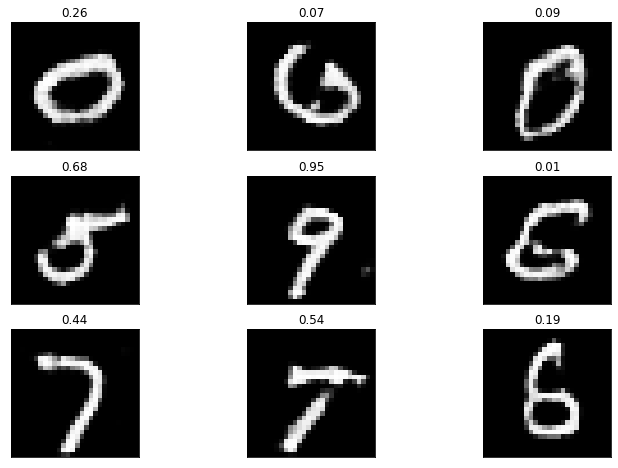

[ 8/10][  1/600] dloss_real=0.4758 dloss_fake=1.7484 gloss=4.7732
[ 8/10][  2/600] dloss_real=1.8809 dloss_fake=0.0677 gloss=1.2497
[ 8/10][  3/600] dloss_real=0.4515 dloss_fake=0.6507 gloss=2.0393
[ 8/10][  4/600] dloss_real=0.6006 dloss_fake=0.2812 gloss=2.1690
[ 8/10][  5/600] dloss_real=0.7386 dloss_fake=0.2185 gloss=1.4681
[ 8/10][  6/600] dloss_real=0.4195 dloss_fake=0.4686 gloss=2.4931
[ 8/10][  7/600] dloss_real=0.6430 dloss_fake=0.2307 gloss=2.0803
[ 8/10][  8/600] dloss_real=0.6791 dloss_fake=0.2183 gloss=1.5612
[ 8/10][  9/600] dloss_real=0.4235 dloss_fake=0.6249 gloss=2.6582
[ 8/10][ 10/600] dloss_real=0.6629 dloss_fake=0.2780 gloss=2.1770
[ 8/10][ 11/600] dloss_real=0.6326 dloss_fake=0.1747 gloss=1.6298
[ 8/10][ 12/600] dloss_real=0.4455 dloss_fake=0.4480 gloss=2.2888
[ 8/10][ 13/600] dloss_real=0.5000 dloss_fake=0.2688 gloss=2.5131
[ 8/10][ 14/600] dloss_real=0.7770 dloss_fake=0.1483 gloss=1.4118
[ 8/10][ 15/600] dloss_real=0.3704 dloss_fake=0.6248 gloss=3.2912
[ 8/10][ 1

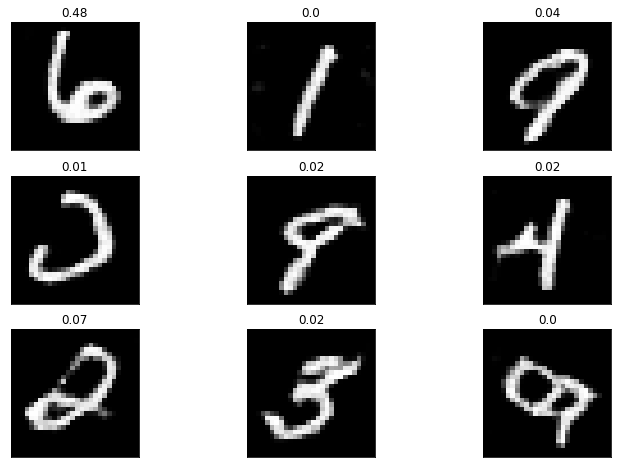

[ 8/10][101/600] dloss_real=0.4488 dloss_fake=0.2898 gloss=2.7849
[ 8/10][102/600] dloss_real=0.7844 dloss_fake=0.0967 gloss=1.4983
[ 8/10][103/600] dloss_real=0.3750 dloss_fake=0.4790 gloss=2.9103
[ 8/10][104/600] dloss_real=0.6971 dloss_fake=0.1535 gloss=1.7019
[ 8/10][105/600] dloss_real=0.5018 dloss_fake=0.3478 gloss=2.1002
[ 8/10][106/600] dloss_real=0.4552 dloss_fake=0.2852 gloss=3.1441
[ 8/10][107/600] dloss_real=0.7262 dloss_fake=0.1103 gloss=1.1526
[ 8/10][108/600] dloss_real=0.3491 dloss_fake=0.7142 gloss=4.1182
[ 8/10][109/600] dloss_real=0.9847 dloss_fake=0.0621 gloss=1.5460
[ 8/10][110/600] dloss_real=0.4167 dloss_fake=0.5026 gloss=2.4230
[ 8/10][111/600] dloss_real=0.6195 dloss_fake=0.1632 gloss=1.8947
[ 8/10][112/600] dloss_real=0.4042 dloss_fake=0.4484 gloss=2.5902
[ 8/10][113/600] dloss_real=0.5324 dloss_fake=0.1400 gloss=2.1531
[ 8/10][114/600] dloss_real=0.5248 dloss_fake=0.3406 gloss=2.1791
[ 8/10][115/600] dloss_real=0.5126 dloss_fake=0.2202 gloss=1.9874
[ 8/10][11

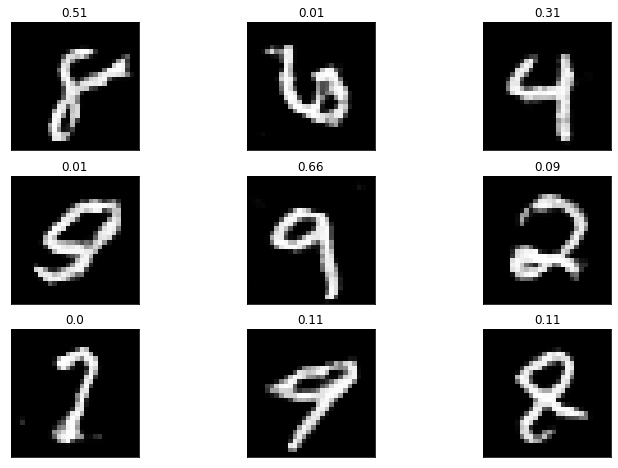

[ 8/10][201/600] dloss_real=0.4458 dloss_fake=0.2261 gloss=2.3171
[ 8/10][202/600] dloss_real=0.4478 dloss_fake=0.2264 gloss=2.4390
[ 8/10][203/600] dloss_real=0.4958 dloss_fake=0.2307 gloss=2.2431
[ 8/10][204/600] dloss_real=0.5980 dloss_fake=0.1608 gloss=1.7101
[ 8/10][205/600] dloss_real=0.3887 dloss_fake=0.6407 gloss=3.3505
[ 8/10][206/600] dloss_real=0.9003 dloss_fake=0.0653 gloss=1.5715
[ 8/10][207/600] dloss_real=0.3887 dloss_fake=0.5381 gloss=2.8158
[ 8/10][208/600] dloss_real=0.7740 dloss_fake=0.1319 gloss=1.6550
[ 8/10][209/600] dloss_real=0.4378 dloss_fake=0.4244 gloss=2.3671
[ 8/10][210/600] dloss_real=0.5718 dloss_fake=0.2024 gloss=2.2197
[ 8/10][211/600] dloss_real=0.5103 dloss_fake=0.2084 gloss=2.2574
[ 8/10][212/600] dloss_real=0.4438 dloss_fake=0.2752 gloss=2.4974
[ 8/10][213/600] dloss_real=0.5116 dloss_fake=0.2405 gloss=2.1311
[ 8/10][214/600] dloss_real=0.5252 dloss_fake=0.2195 gloss=1.9816
[ 8/10][215/600] dloss_real=0.4951 dloss_fake=0.2354 gloss=2.0520
[ 8/10][21

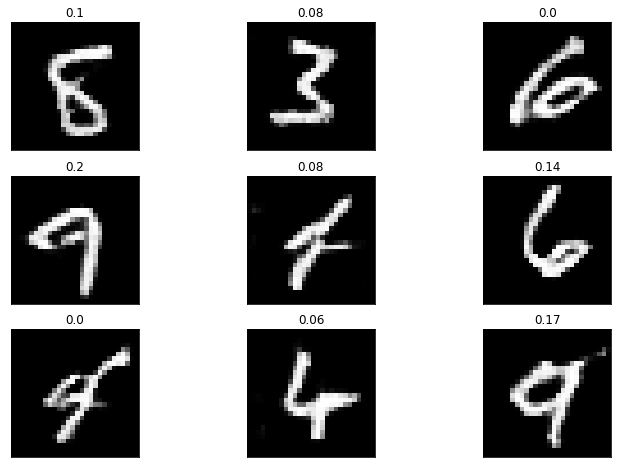

[ 8/10][301/600] dloss_real=0.4285 dloss_fake=0.4365 gloss=2.2903
[ 8/10][302/600] dloss_real=0.4756 dloss_fake=0.2972 gloss=2.6448
[ 8/10][303/600] dloss_real=0.6545 dloss_fake=0.1646 gloss=1.7497
[ 8/10][304/600] dloss_real=0.4194 dloss_fake=0.2232 gloss=2.1223
[ 8/10][305/600] dloss_real=0.5798 dloss_fake=0.2858 gloss=1.9008
[ 8/10][306/600] dloss_real=0.4713 dloss_fake=0.2553 gloss=2.3808
[ 8/10][307/600] dloss_real=0.4942 dloss_fake=0.2238 gloss=2.4408
[ 8/10][308/600] dloss_real=0.5589 dloss_fake=0.3406 gloss=2.1788
[ 8/10][309/600] dloss_real=0.5736 dloss_fake=0.1419 gloss=2.0718
[ 8/10][310/600] dloss_real=0.4144 dloss_fake=0.4098 gloss=2.6591
[ 8/10][311/600] dloss_real=0.8147 dloss_fake=0.1549 gloss=1.1087
[ 8/10][312/600] dloss_real=0.3643 dloss_fake=0.5607 gloss=3.1846
[ 8/10][313/600] dloss_real=0.5632 dloss_fake=0.1310 gloss=2.6640
[ 8/10][314/600] dloss_real=0.5448 dloss_fake=0.1508 gloss=1.7919
[ 8/10][315/600] dloss_real=0.3716 dloss_fake=0.3910 gloss=2.8436
[ 8/10][31

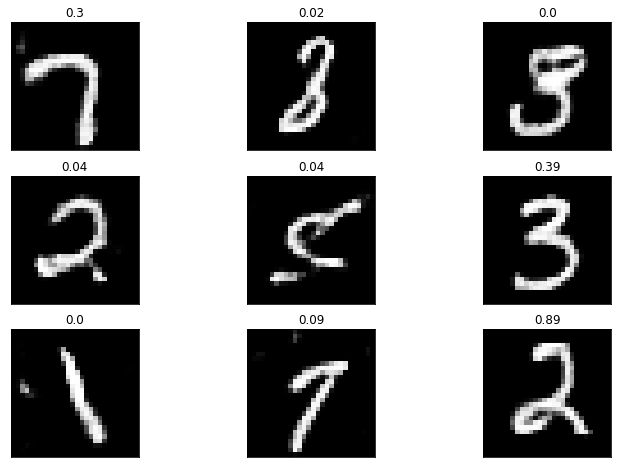

[ 8/10][401/600] dloss_real=0.4215 dloss_fake=0.2995 gloss=2.4704
[ 8/10][402/600] dloss_real=0.4568 dloss_fake=0.2713 gloss=2.8001
[ 8/10][403/600] dloss_real=0.7536 dloss_fake=0.2277 gloss=1.3782
[ 8/10][404/600] dloss_real=0.4071 dloss_fake=0.4650 gloss=3.1751
[ 8/10][405/600] dloss_real=0.7457 dloss_fake=0.1391 gloss=1.6678
[ 8/10][406/600] dloss_real=0.3819 dloss_fake=0.2695 gloss=2.6945
[ 8/10][407/600] dloss_real=0.6246 dloss_fake=0.2549 gloss=1.8641
[ 8/10][408/600] dloss_real=0.4913 dloss_fake=0.2580 gloss=2.1619
[ 8/10][409/600] dloss_real=0.4409 dloss_fake=0.3061 gloss=2.7279
[ 8/10][410/600] dloss_real=0.5862 dloss_fake=0.1766 gloss=2.0950
[ 8/10][411/600] dloss_real=0.5903 dloss_fake=0.2961 gloss=1.9027
[ 8/10][412/600] dloss_real=0.4594 dloss_fake=0.4182 gloss=2.9089
[ 8/10][413/600] dloss_real=0.7851 dloss_fake=0.1411 gloss=1.5503
[ 8/10][414/600] dloss_real=0.4349 dloss_fake=0.3571 gloss=2.6294
[ 8/10][415/600] dloss_real=0.4976 dloss_fake=0.1951 gloss=2.3071
[ 8/10][41

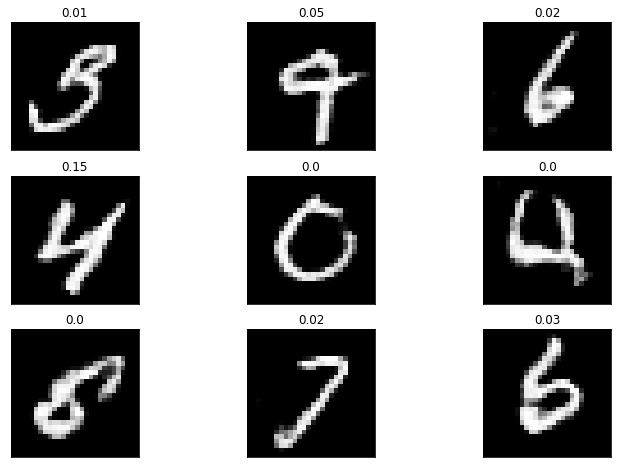

[ 8/10][501/600] dloss_real=0.6946 dloss_fake=0.1316 gloss=1.7063
[ 8/10][502/600] dloss_real=0.3904 dloss_fake=0.3384 gloss=2.6218
[ 8/10][503/600] dloss_real=0.3825 dloss_fake=0.1794 gloss=3.5477
[ 8/10][504/600] dloss_real=0.6846 dloss_fake=0.1711 gloss=1.4440
[ 8/10][505/600] dloss_real=0.4524 dloss_fake=0.3405 gloss=2.2883
[ 8/10][506/600] dloss_real=0.4451 dloss_fake=0.2438 gloss=2.8684
[ 8/10][507/600] dloss_real=0.5521 dloss_fake=0.1951 gloss=1.9710
[ 8/10][508/600] dloss_real=0.5068 dloss_fake=0.3115 gloss=2.3410
[ 8/10][509/600] dloss_real=0.4683 dloss_fake=0.3351 gloss=2.5920
[ 8/10][510/600] dloss_real=0.5650 dloss_fake=0.1877 gloss=1.9839
[ 8/10][511/600] dloss_real=0.6132 dloss_fake=0.2511 gloss=1.4519
[ 8/10][512/600] dloss_real=0.4005 dloss_fake=0.4118 gloss=3.2718
[ 8/10][513/600] dloss_real=0.7319 dloss_fake=0.1667 gloss=1.8321
[ 8/10][514/600] dloss_real=0.5033 dloss_fake=0.4096 gloss=2.5731
[ 8/10][515/600] dloss_real=0.6824 dloss_fake=0.2234 gloss=1.5455
[ 8/10][51

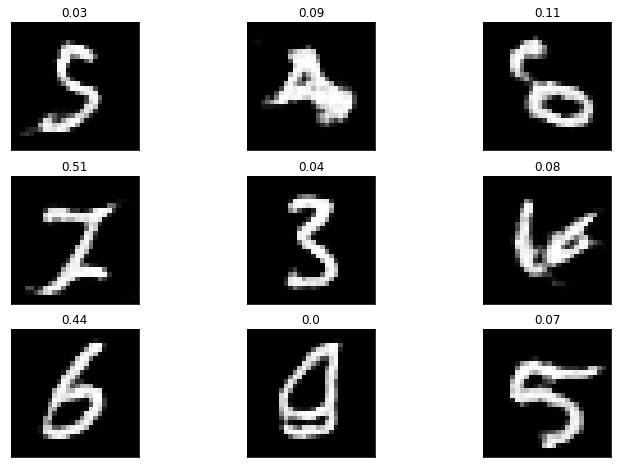

[ 9/10][  1/600] dloss_real=0.3885 dloss_fake=0.5337 gloss=4.0852
[ 9/10][  2/600] dloss_real=1.0619 dloss_fake=0.0560 gloss=1.5965
[ 9/10][  3/600] dloss_real=0.3776 dloss_fake=0.4384 gloss=2.6867
[ 9/10][  4/600] dloss_real=0.6448 dloss_fake=0.2715 gloss=1.7499
[ 9/10][  5/600] dloss_real=0.4655 dloss_fake=0.2320 gloss=2.4259
[ 9/10][  6/600] dloss_real=0.5373 dloss_fake=0.2130 gloss=1.9094
[ 9/10][  7/600] dloss_real=0.3861 dloss_fake=0.4254 gloss=3.0437
[ 9/10][  8/600] dloss_real=0.7307 dloss_fake=0.0937 gloss=2.1296
[ 9/10][  9/600] dloss_real=0.4410 dloss_fake=0.2232 gloss=2.0437
[ 9/10][ 10/600] dloss_real=0.4096 dloss_fake=0.3734 gloss=3.2984
[ 9/10][ 11/600] dloss_real=0.8966 dloss_fake=0.1203 gloss=1.5565
[ 9/10][ 12/600] dloss_real=0.4429 dloss_fake=0.4722 gloss=2.3295
[ 9/10][ 13/600] dloss_real=0.6063 dloss_fake=0.1606 gloss=1.8935
[ 9/10][ 14/600] dloss_real=0.4096 dloss_fake=0.3480 gloss=2.7808
[ 9/10][ 15/600] dloss_real=0.6785 dloss_fake=0.1426 gloss=1.6605
[ 9/10][ 1

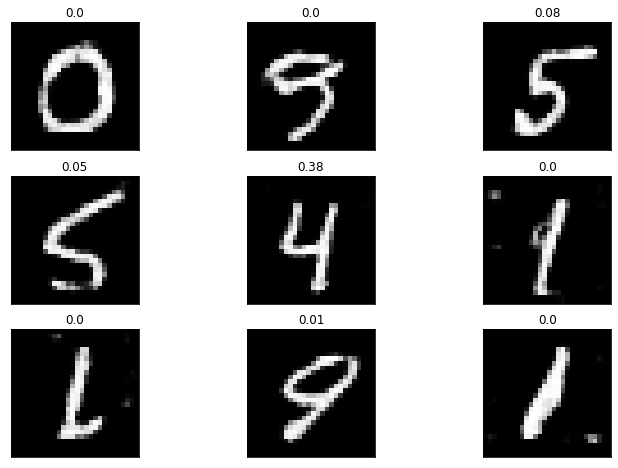

[ 9/10][101/600] dloss_real=0.9252 dloss_fake=0.1030 gloss=1.3420
[ 9/10][102/600] dloss_real=0.3616 dloss_fake=0.5071 gloss=2.8831
[ 9/10][103/600] dloss_real=0.6368 dloss_fake=0.1310 gloss=2.3274
[ 9/10][104/600] dloss_real=0.4830 dloss_fake=0.2579 gloss=2.0976
[ 9/10][105/600] dloss_real=0.4254 dloss_fake=0.3148 gloss=2.5907
[ 9/10][106/600] dloss_real=0.6051 dloss_fake=0.3128 gloss=2.0842
[ 9/10][107/600] dloss_real=0.5456 dloss_fake=0.2075 gloss=1.9682
[ 9/10][108/600] dloss_real=0.5130 dloss_fake=0.2350 gloss=2.0099
[ 9/10][109/600] dloss_real=0.4422 dloss_fake=0.4703 gloss=2.7264
[ 9/10][110/600] dloss_real=0.6762 dloss_fake=0.1584 gloss=2.0463
[ 9/10][111/600] dloss_real=0.5280 dloss_fake=0.2749 gloss=1.8972
[ 9/10][112/600] dloss_real=0.4887 dloss_fake=0.3728 gloss=2.1310
[ 9/10][113/600] dloss_real=0.4952 dloss_fake=0.2434 gloss=2.2732
[ 9/10][114/600] dloss_real=0.5107 dloss_fake=0.1548 gloss=2.0586
[ 9/10][115/600] dloss_real=0.4690 dloss_fake=0.3904 gloss=2.4724
[ 9/10][11

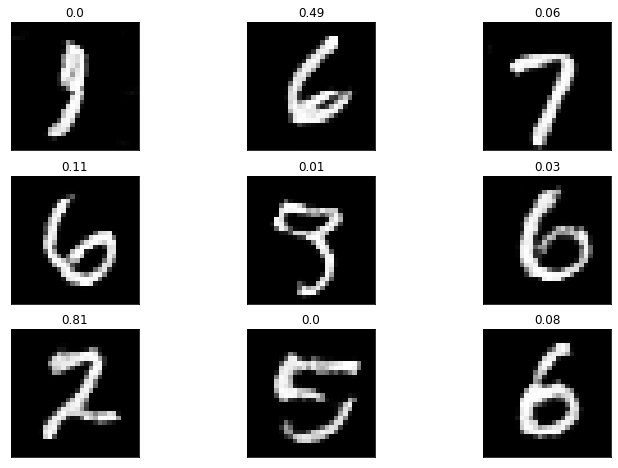

[ 9/10][201/600] dloss_real=0.4617 dloss_fake=0.3735 gloss=2.4393
[ 9/10][202/600] dloss_real=0.5269 dloss_fake=0.2223 gloss=2.1988
[ 9/10][203/600] dloss_real=0.5027 dloss_fake=0.2524 gloss=2.3737
[ 9/10][204/600] dloss_real=0.5654 dloss_fake=0.2044 gloss=2.0873
[ 9/10][205/600] dloss_real=0.4178 dloss_fake=0.2834 gloss=2.8566
[ 9/10][206/600] dloss_real=0.6020 dloss_fake=0.2476 gloss=1.8263
[ 9/10][207/600] dloss_real=0.4384 dloss_fake=0.4308 gloss=2.8170
[ 9/10][208/600] dloss_real=0.7600 dloss_fake=0.1184 gloss=1.3616
[ 9/10][209/600] dloss_real=0.3969 dloss_fake=0.4251 gloss=2.6579
[ 9/10][210/600] dloss_real=0.4610 dloss_fake=0.1825 gloss=2.7234
[ 9/10][211/600] dloss_real=0.7651 dloss_fake=0.1571 gloss=1.1695
[ 9/10][212/600] dloss_real=0.3395 dloss_fake=1.0514 gloss=4.9699
[ 9/10][213/600] dloss_real=1.8228 dloss_fake=0.0291 gloss=1.4607
[ 9/10][214/600] dloss_real=0.4613 dloss_fake=0.3963 gloss=3.1688
[ 9/10][215/600] dloss_real=1.0621 dloss_fake=0.2489 gloss=0.4482
[ 9/10][21

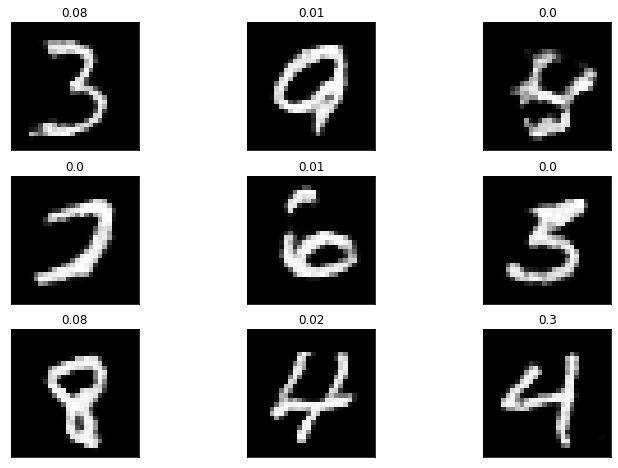

[ 9/10][301/600] dloss_real=1.0635 dloss_fake=0.0765 gloss=1.4862
[ 9/10][302/600] dloss_real=0.4130 dloss_fake=0.4702 gloss=2.0943
[ 9/10][303/600] dloss_real=0.5322 dloss_fake=0.2120 gloss=2.2722
[ 9/10][304/600] dloss_real=0.4970 dloss_fake=0.3911 gloss=2.3238
[ 9/10][305/600] dloss_real=0.6528 dloss_fake=0.1785 gloss=1.6271
[ 9/10][306/600] dloss_real=0.4360 dloss_fake=0.4862 gloss=2.5094
[ 9/10][307/600] dloss_real=0.7090 dloss_fake=0.1123 gloss=1.7574
[ 9/10][308/600] dloss_real=0.4002 dloss_fake=0.3799 gloss=2.1019
[ 9/10][309/600] dloss_real=0.4328 dloss_fake=0.3236 gloss=2.8339
[ 9/10][310/600] dloss_real=0.7583 dloss_fake=0.1236 gloss=1.6798
[ 9/10][311/600] dloss_real=0.4392 dloss_fake=0.4230 gloss=2.1956
[ 9/10][312/600] dloss_real=0.4387 dloss_fake=0.2186 gloss=2.6981
[ 9/10][313/600] dloss_real=0.5565 dloss_fake=0.1791 gloss=1.8594
[ 9/10][314/600] dloss_real=0.4117 dloss_fake=0.3119 gloss=2.1677
[ 9/10][315/600] dloss_real=0.5016 dloss_fake=0.3207 gloss=2.4205
[ 9/10][31

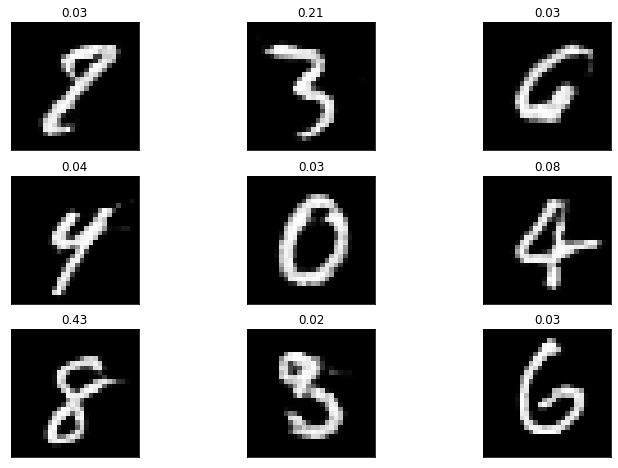

[ 9/10][401/600] dloss_real=0.5026 dloss_fake=0.2046 gloss=2.0480
[ 9/10][402/600] dloss_real=0.4445 dloss_fake=0.3238 gloss=2.6475
[ 9/10][403/600] dloss_real=0.6044 dloss_fake=0.1569 gloss=1.7857
[ 9/10][404/600] dloss_real=0.3851 dloss_fake=0.4015 gloss=2.7154
[ 9/10][405/600] dloss_real=0.6271 dloss_fake=0.1658 gloss=1.9240
[ 9/10][406/600] dloss_real=0.3891 dloss_fake=0.1713 gloss=2.4852
[ 9/10][407/600] dloss_real=0.4753 dloss_fake=0.3065 gloss=2.5234
[ 9/10][408/600] dloss_real=0.5584 dloss_fake=0.2092 gloss=2.0542
[ 9/10][409/600] dloss_real=0.6203 dloss_fake=0.2373 gloss=1.4523
[ 9/10][410/600] dloss_real=0.3857 dloss_fake=0.4285 gloss=2.9845
[ 9/10][411/600] dloss_real=0.5955 dloss_fake=0.1492 gloss=2.1243
[ 9/10][412/600] dloss_real=0.5356 dloss_fake=0.3737 gloss=2.0070
[ 9/10][413/600] dloss_real=0.5116 dloss_fake=0.2340 gloss=2.4212
[ 9/10][414/600] dloss_real=0.5053 dloss_fake=0.2430 gloss=2.3031
[ 9/10][415/600] dloss_real=0.4696 dloss_fake=0.2665 gloss=2.4505
[ 9/10][41

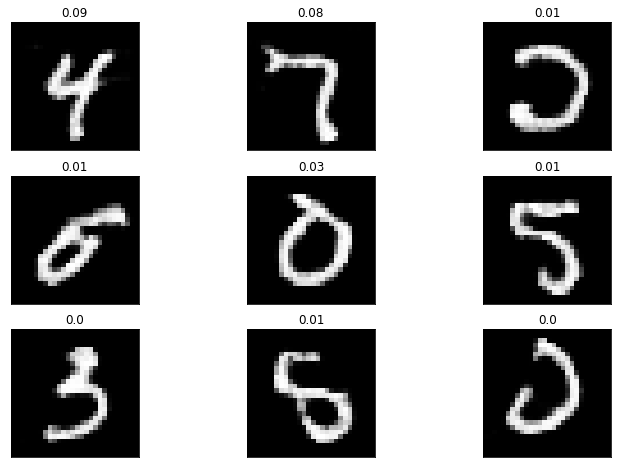

[ 9/10][501/600] dloss_real=0.4396 dloss_fake=0.3394 gloss=2.3168
[ 9/10][502/600] dloss_real=0.6308 dloss_fake=0.1272 gloss=1.9188
[ 9/10][503/600] dloss_real=0.4048 dloss_fake=0.2613 gloss=2.1876
[ 9/10][504/600] dloss_real=0.5848 dloss_fake=0.3534 gloss=2.1692
[ 9/10][505/600] dloss_real=0.5161 dloss_fake=0.2237 gloss=2.0892
[ 9/10][506/600] dloss_real=0.4868 dloss_fake=0.2824 gloss=2.3211
[ 9/10][507/600] dloss_real=0.6026 dloss_fake=0.2207 gloss=1.6704
[ 9/10][508/600] dloss_real=0.4243 dloss_fake=0.3330 gloss=2.4724
[ 9/10][509/600] dloss_real=0.5351 dloss_fake=0.2346 gloss=2.0417
[ 9/10][510/600] dloss_real=0.4482 dloss_fake=0.2133 gloss=2.4152
[ 9/10][511/600] dloss_real=0.5579 dloss_fake=0.2149 gloss=1.8135
[ 9/10][512/600] dloss_real=0.4319 dloss_fake=0.3435 gloss=2.3587
[ 9/10][513/600] dloss_real=0.5605 dloss_fake=0.3053 gloss=2.0586
[ 9/10][514/600] dloss_real=0.5472 dloss_fake=0.2382 gloss=1.9767
[ 9/10][515/600] dloss_real=0.4613 dloss_fake=0.2958 gloss=2.6377
[ 9/10][51

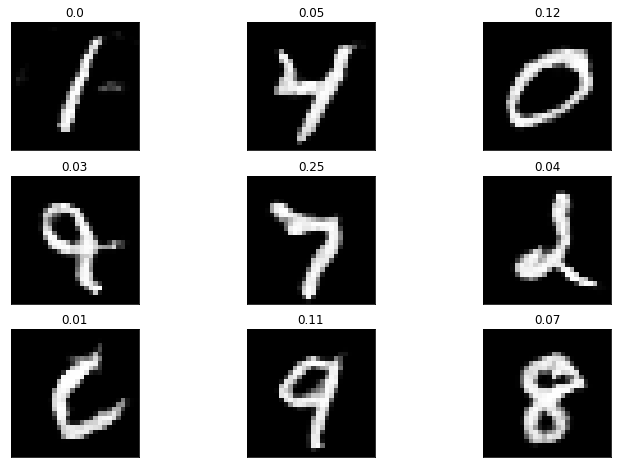

[10/10][  1/600] dloss_real=0.5253 dloss_fake=0.2741 gloss=1.9520
[10/10][  2/600] dloss_real=0.5110 dloss_fake=0.3046 gloss=2.3521
[10/10][  3/600] dloss_real=0.5590 dloss_fake=0.2082 gloss=1.9862
[10/10][  4/600] dloss_real=0.4742 dloss_fake=0.1922 gloss=2.0720
[10/10][  5/600] dloss_real=0.4906 dloss_fake=0.4084 gloss=2.3317
[10/10][  6/600] dloss_real=0.5540 dloss_fake=0.2110 gloss=2.3992
[10/10][  7/600] dloss_real=0.4900 dloss_fake=0.2614 gloss=2.2493
[10/10][  8/600] dloss_real=0.5946 dloss_fake=0.2118 gloss=1.6918
[10/10][  9/600] dloss_real=0.4150 dloss_fake=0.4897 gloss=2.7682
[10/10][ 10/600] dloss_real=0.5723 dloss_fake=0.1451 gloss=2.2562
[10/10][ 11/600] dloss_real=0.5318 dloss_fake=0.1735 gloss=1.7605
[10/10][ 12/600] dloss_real=0.3824 dloss_fake=0.2647 gloss=3.0413
[10/10][ 13/600] dloss_real=0.6119 dloss_fake=0.1806 gloss=2.0651
[10/10][ 14/600] dloss_real=0.4517 dloss_fake=0.3170 gloss=2.4971
[10/10][ 15/600] dloss_real=0.4818 dloss_fake=0.2147 gloss=2.4276
[10/10][ 1

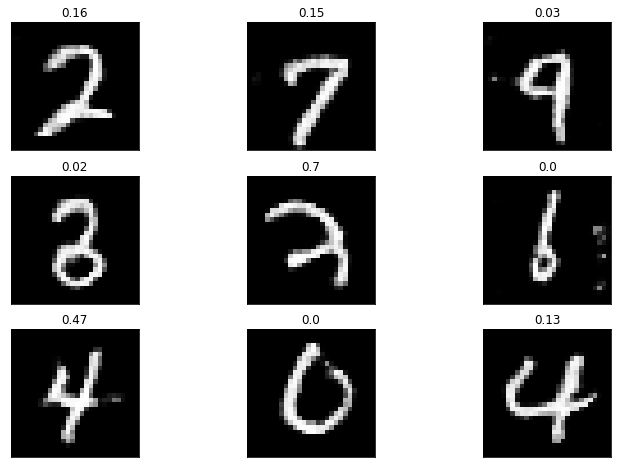

[10/10][101/600] dloss_real=0.5994 dloss_fake=0.1526 gloss=1.9390
[10/10][102/600] dloss_real=0.4633 dloss_fake=0.2703 gloss=2.1618
[10/10][103/600] dloss_real=0.5054 dloss_fake=0.2025 gloss=2.3022
[10/10][104/600] dloss_real=0.4605 dloss_fake=0.3207 gloss=2.3776
[10/10][105/600] dloss_real=0.5568 dloss_fake=0.2792 gloss=2.1452
[10/10][106/600] dloss_real=0.6231 dloss_fake=0.1803 gloss=1.6490
[10/10][107/600] dloss_real=0.3827 dloss_fake=0.3544 gloss=3.1667
[10/10][108/600] dloss_real=0.7739 dloss_fake=0.1879 gloss=1.6047
[10/10][109/600] dloss_real=0.4464 dloss_fake=0.2791 gloss=2.6911
[10/10][110/600] dloss_real=0.4347 dloss_fake=0.2964 gloss=3.3126
[10/10][111/600] dloss_real=0.7277 dloss_fake=0.1305 gloss=1.3856
[10/10][112/600] dloss_real=0.3702 dloss_fake=0.4741 gloss=2.5321
[10/10][113/600] dloss_real=0.5084 dloss_fake=0.2936 gloss=2.6365
[10/10][114/600] dloss_real=0.5697 dloss_fake=0.1134 gloss=2.0052
[10/10][115/600] dloss_real=0.4006 dloss_fake=0.3267 gloss=2.5743
[10/10][11

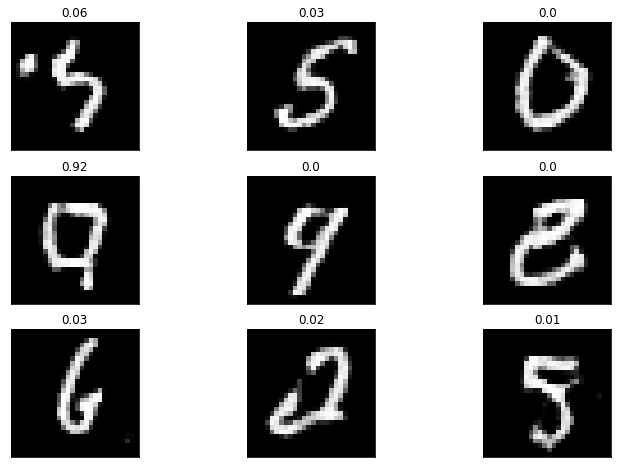

[10/10][201/600] dloss_real=0.4338 dloss_fake=0.2987 gloss=2.4327
[10/10][202/600] dloss_real=0.5120 dloss_fake=0.2232 gloss=2.2023
[10/10][203/600] dloss_real=0.4790 dloss_fake=0.3432 gloss=2.6948
[10/10][204/600] dloss_real=0.5887 dloss_fake=0.1267 gloss=2.0033
[10/10][205/600] dloss_real=0.4345 dloss_fake=0.2691 gloss=2.3048
[10/10][206/600] dloss_real=0.4905 dloss_fake=0.2194 gloss=2.5910
[10/10][207/600] dloss_real=0.5061 dloss_fake=0.2523 gloss=2.2551
[10/10][208/600] dloss_real=0.4164 dloss_fake=0.3142 gloss=3.0227
[10/10][209/600] dloss_real=0.7555 dloss_fake=0.1185 gloss=1.4089
[10/10][210/600] dloss_real=0.3927 dloss_fake=0.4639 gloss=3.0992
[10/10][211/600] dloss_real=0.6097 dloss_fake=0.1149 gloss=2.0125
[10/10][212/600] dloss_real=0.4815 dloss_fake=0.2303 gloss=1.9865
[10/10][213/600] dloss_real=0.4096 dloss_fake=0.2939 gloss=2.8932
[10/10][214/600] dloss_real=0.5645 dloss_fake=0.1365 gloss=2.4286
[10/10][215/600] dloss_real=0.4646 dloss_fake=0.3008 gloss=2.2371
[10/10][21

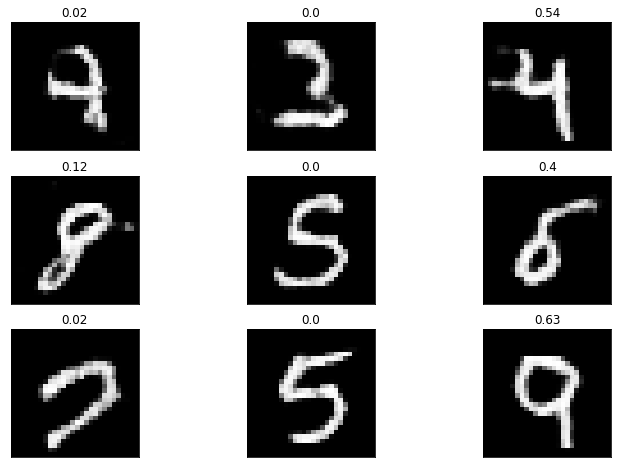

[10/10][301/600] dloss_real=0.4139 dloss_fake=0.4539 gloss=3.6751
[10/10][302/600] dloss_real=1.2245 dloss_fake=0.0397 gloss=1.5041
[10/10][303/600] dloss_real=0.4090 dloss_fake=0.5106 gloss=2.5804
[10/10][304/600] dloss_real=0.5369 dloss_fake=0.2504 gloss=2.3226
[10/10][305/600] dloss_real=0.5052 dloss_fake=0.3137 gloss=2.3764
[10/10][306/600] dloss_real=0.5835 dloss_fake=0.1660 gloss=1.7794
[10/10][307/600] dloss_real=0.5260 dloss_fake=0.4650 gloss=2.0682
[10/10][308/600] dloss_real=0.5229 dloss_fake=0.3513 gloss=2.4635
[10/10][309/600] dloss_real=0.5564 dloss_fake=0.2091 gloss=2.2896
[10/10][310/600] dloss_real=0.5999 dloss_fake=0.1141 gloss=1.8059
[10/10][311/600] dloss_real=0.3633 dloss_fake=0.4405 gloss=2.9766
[10/10][312/600] dloss_real=0.5159 dloss_fake=0.1708 gloss=2.6263
[10/10][313/600] dloss_real=0.5741 dloss_fake=0.1743 gloss=1.8014
[10/10][314/600] dloss_real=0.4071 dloss_fake=0.5140 gloss=3.0629
[10/10][315/600] dloss_real=1.1405 dloss_fake=0.0781 gloss=1.0869
[10/10][31

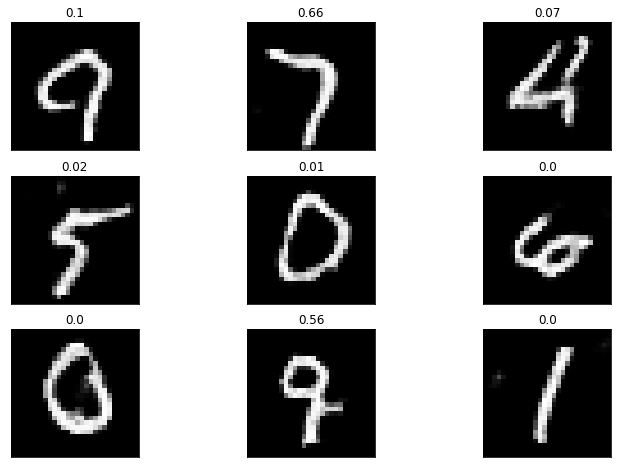

[10/10][401/600] dloss_real=0.5791 dloss_fake=0.2650 gloss=1.7158
[10/10][402/600] dloss_real=0.3736 dloss_fake=0.4682 gloss=3.6148
[10/10][403/600] dloss_real=0.6960 dloss_fake=0.1072 gloss=2.3770
[10/10][404/600] dloss_real=0.5659 dloss_fake=0.2255 gloss=1.7370
[10/10][405/600] dloss_real=0.4023 dloss_fake=0.3579 gloss=2.9171
[10/10][406/600] dloss_real=0.5511 dloss_fake=0.1315 gloss=2.4212
[10/10][407/600] dloss_real=0.6046 dloss_fake=0.3415 gloss=1.4573
[10/10][408/600] dloss_real=0.4347 dloss_fake=0.2491 gloss=2.4498
[10/10][409/600] dloss_real=0.4757 dloss_fake=0.3175 gloss=2.5766
[10/10][410/600] dloss_real=0.5048 dloss_fake=0.1581 gloss=2.3287
[10/10][411/600] dloss_real=0.4993 dloss_fake=0.2657 gloss=2.0370
[10/10][412/600] dloss_real=0.5442 dloss_fake=0.2064 gloss=1.8716
[10/10][413/600] dloss_real=0.3693 dloss_fake=0.4168 gloss=3.4713
[10/10][414/600] dloss_real=0.6988 dloss_fake=0.1063 gloss=1.9653
[10/10][415/600] dloss_real=0.4420 dloss_fake=0.3846 gloss=2.4487
[10/10][41

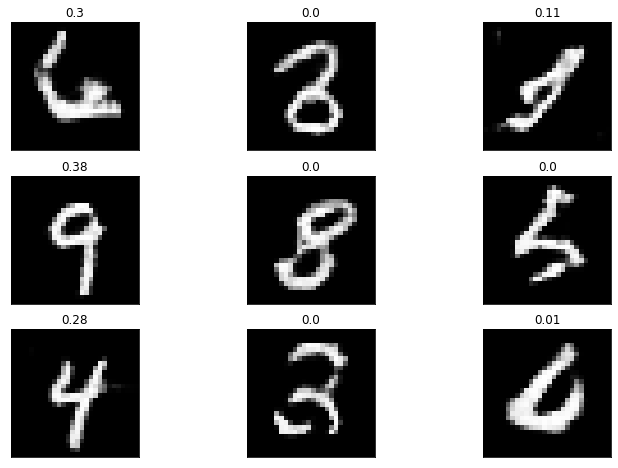

[10/10][501/600] dloss_real=0.7308 dloss_fake=0.1361 gloss=1.7701
[10/10][502/600] dloss_real=0.4277 dloss_fake=0.4001 gloss=3.1357
[10/10][503/600] dloss_real=0.8213 dloss_fake=0.1662 gloss=1.6155
[10/10][504/600] dloss_real=0.3690 dloss_fake=0.3953 gloss=3.2209
[10/10][505/600] dloss_real=0.8748 dloss_fake=0.1882 gloss=1.2575
[10/10][506/600] dloss_real=0.3982 dloss_fake=0.7057 gloss=3.4143
[10/10][507/600] dloss_real=0.8715 dloss_fake=0.0732 gloss=2.0386
[10/10][508/600] dloss_real=0.4463 dloss_fake=0.4232 gloss=2.6202
[10/10][509/600] dloss_real=0.6334 dloss_fake=0.1886 gloss=1.9831
[10/10][510/600] dloss_real=0.4779 dloss_fake=0.3081 gloss=2.3125
[10/10][511/600] dloss_real=0.5286 dloss_fake=0.2412 gloss=2.1907
[10/10][512/600] dloss_real=0.4659 dloss_fake=0.1998 gloss=2.5307
[10/10][513/600] dloss_real=0.4345 dloss_fake=0.1595 gloss=2.6935
[10/10][514/600] dloss_real=0.5478 dloss_fake=0.2996 gloss=2.0920
[10/10][515/600] dloss_real=0.4379 dloss_fake=0.1858 gloss=2.4689
[10/10][51

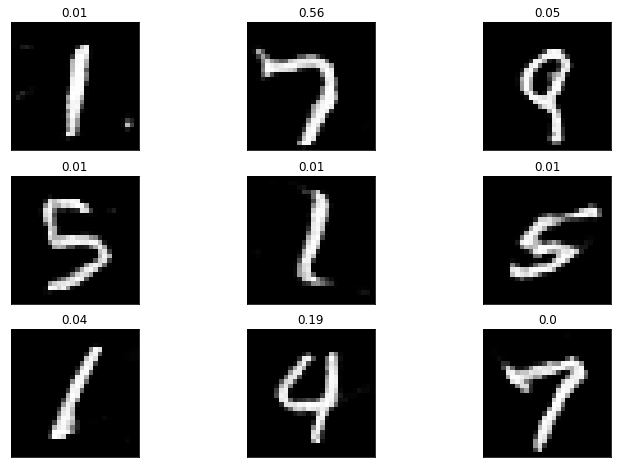

total time 2496.850247859955 s


In [9]:
train(10)

In [10]:
torch.save(gen.state_dict(),'mnist-gan-gen.pt')
torch.save(discr.state_dict(),'mnist-gan-discr.pt')

In [70]:
gen.load_state_dict(torch.load('mnist-gan-gen.pt'))
discr.load_state_dict(torch.load('mnist-gan-discr.pt'))

<All keys matched successfully>

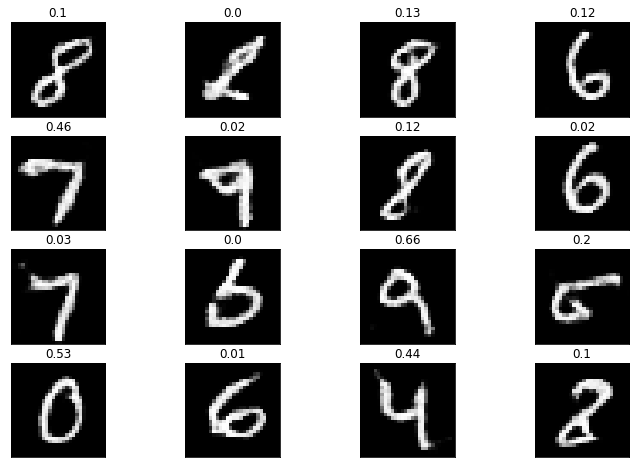

In [22]:
showimgs(4)

In [23]:
# exp moving avg in numpy (https://stackoverflow.com/a/42926270)
def ema(data, window):
    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

Notice the sharp drop in gen loss during first couple hundred iterations:

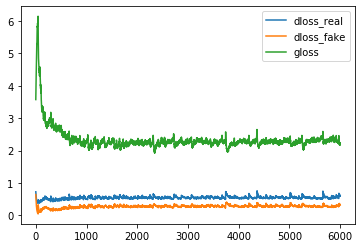

In [27]:
wnd=30
for name,vals in losses.items():
    # smooth data w/ ema for less noisiness
    plt.plot(ema(np.asarray(vals),wnd),label=name)
plt.legend()

### Vector arithmetic

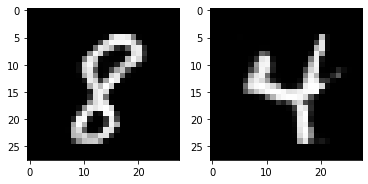

In [24]:
torch.manual_seed(17)
im1,z1=genimg()
im2,z2=genimg()
plt.subplot(121).imshow(im1,cmap='gray')
plt.subplot(122).imshow(im2,cmap='gray')
plt.show()

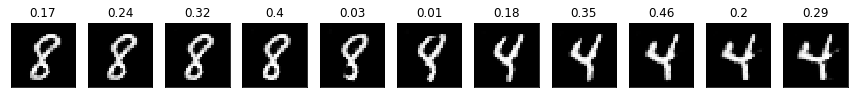

In [25]:
n=10
zs=[z1+(z2-z1)*i/n for i in range(n+1)] # interpolate between im1 and im2 in z space
probs=[round(discr(gen(z)).item(),2) for z in zs]
imgs=[z2img(z) for z in zs]
plt.figure(figsize=(15,7))
for i,(img,prob) in enumerate(zip(imgs,probs)):
    ax=plt.subplot(1,n+1,i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(prob)
    ax.imshow(img,cmap='gray')

Some intermediate images have higher probs than z1, z2. It IMO suggests that there are some optimum images in z space, but we just happened to choose some random z1 and z2.